In [ ]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget
!pip install mdatagen
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget
!pip install numpy scipy sklearn
!pip install jax
!pip install chex
!pip install attr
!pip install optax



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute



c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from Utils import *
from SoftImpute import softimpute, cv_softimpute
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import *
from RR_imputer import RRimputer
import matplotlib.pyplot as plt
from CMI import *

from Inject_Missing_Values import *

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")
import pandas as pd

torch.set_default_tensor_type('torch.DoubleTensor')

**Load Data**

In [ ]:
import pandas as pd

# Read CSV file into a Pandas DataFrame
groundTruth = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\abalone\abalone.csv', delimiter=',', header=0)

In [ ]:
groundTruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   int64  
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


Checking Number of unique values

In [ ]:
groundTruth.nunique()

Sex                 3
Length            134
Diameter          111
Height             51
WholeWeight      2429
ShuckedWeight    1515
VisceraWeight     880
ShellWeight       926
Rings              28
dtype: int64

In [ ]:
groundTruth.head(5)

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,3,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:

scaler = StandardScaler()
groundTruth_scaled = pd.DataFrame(scaler.fit_transform(groundTruth), columns=groundTruth.columns)

In [ ]:
print(groundTruth_scaled)


           Sex    Length  Diameter    Height  WholeWeight  ShuckedWeight  \
0    -1.154346 -0.574558 -0.432149 -1.064424    -0.641898      -0.607685   
1    -1.154346 -1.448986 -1.439929 -1.183978    -1.230277      -1.170910   
2     0.053798  0.050033  0.122130 -0.107991    -0.309469      -0.463500   
3    -1.154346 -0.699476 -0.432149 -0.347099    -0.637819      -0.648238   
4     1.261943 -1.615544 -1.540707 -1.423087    -1.272086      -1.215968   
...        ...       ...       ...       ...          ...            ...   
4172  0.053798  0.341509  0.424464  0.609334     0.118813       0.047908   
4173 -1.154346  0.549706  0.323686 -0.107991     0.279929       0.358808   
4174 -1.154346  0.632985  0.676409  1.565767     0.708212       0.748559   
4175  0.053798  0.841182  0.777187  0.250672     0.541998       0.773341   
4176 -1.154346  1.549052  1.482634  1.326659     2.283681       2.640993   

      VisceraWeight  ShellWeight     Rings  
0         -0.726212    -0.638217  1.571544

In [ ]:
X= groundTruth_scaled.iloc[:, :-1]  # Selects all rows and all columns except the last one
Y = groundTruth_scaled.iloc[:, -1]  # Selects all rows and only the last column

In [ ]:
print("Sex",groundTruth_scaled['Sex'].unique())
print("Length",groundTruth_scaled['Length'].median())
print("Diameter",groundTruth_scaled['Diameter'].median())
print('Height',groundTruth_scaled['Height'].median())
print('WholeWeight',groundTruth_scaled['WholeWeight'].median())
print('ShuckedWeight',groundTruth_scaled['ShuckedWeight'].median())
print('VisceraWeight',groundTruth_scaled['VisceraWeight'].median())
print('ShellWeight',groundTruth_scaled['ShellWeight'].median())
print('Rings',groundTruth_scaled['Rings'].unique())

Sex [-1.15434629  0.05379815  1.26194258]
Length 0.1749513366064497
Diameter 0.1725193283071389
Height 0.011563294395590387
WholeWeight -0.05963767409985407
ShuckedWeight -0.10528913223586027
VisceraWeight -0.08753201724211666
ShellWeight -0.03470793956736384
Rings [ 1.57154357 -0.91001299 -0.28962385  0.02057072 -0.59981842  3.12251641
  1.88173814  2.81232184  1.261349    0.33076529  0.64095986  2.50212727
  0.95115443 -1.53040213 -1.8405967  -1.22020756  3.43271098  2.19193271
  3.74290555 -2.77118041 -2.15079127  4.98368383  4.05310012  5.91426754
 -2.46098584  5.2938784   4.67348926  4.36329469]


Converting GroudTruth to Tensor

In [ ]:
groundTruth_tensor = torch.tensor((groundTruth_scaled.to_numpy()))

In [ ]:
print(torch.unique(groundTruth_tensor[:,0])) 

tensor([-1.1543,  0.0538,  1.2619])


In [ ]:
print("minimum: ",groundTruth_tensor.min())
print("maximum:",groundTruth_tensor.max())
print("mean: ",groundTruth_tensor.mean())
print("median: ", groundTruth_tensor.median())

minimum:  tensor(-3.7392)
maximum: tensor(23.6833)
mean:  tensor(2.1547e-17)
median:  tensor(0.0206)


Determining the appropriate columns for bucketization along with their respective bucket sizes, and identifying the variables X, Y, and Z for Conditional Mutual Information (CMI) computation.

In [ ]:
bucket_specs = {
     0:3,
     1:10,
     2:10,
     3:10,
     5:10,
     7:10,
     8:4
    
    
    
}

# Define multiple attributes for X, Y, Z
X_cols = [0]  # Bucketized sensitive attributes (e.g., sex, race, age)
Y_cols = [8]     # Bucketized outcome-related attributes
Z_cols = [1,2,3,5,7]  


**CMI for GroundTruth**

In [ ]:
#groundTruth_tensor = groundTruth_tensor.float()
groundTruth_tensor.requires_grad=True
cmi_groundTruth = CMI.c_m_i(groundTruth_tensor,bucket_specs,X_cols, Y_cols, Z_cols)
print(cmi_groundTruth)

H(X|Z): 0.5971075786387825, H(Y|Z): 0.9049612859878042, H(X,Y|Z): 1.2766783375304342
tensor(0.2254, grad_fn=<ClampBackward1>)


Generating MCAR 25%, and added the target coloumn with the 25% missing MCAR data

In [ ]:
generator_mcar25 = Inject_Missing_Values()
miss_mcar25,index_mcar25 = generator_mcar25.MCAR(X,missing_rate=25)
print(type(miss_mcar25))
total_missing_percentage_mar25= miss_mcar25.isnull().sum().sum() / miss_mcar25.size * 100
print(f"Total Missing Percentage MAR25: {total_missing_percentage_mar25:.2f}%")

missing_percentage = (miss_mcar25.isnull().sum() / len(miss_mcar25)) * 100
print(missing_percentage)

miss_mcar25 = pd.concat([miss_mcar25, Y], axis=1) #adding the target coloumn

<class 'pandas.core.frame.DataFrame'>
Total Missing Percentage MAR25: 25.00%
Sex              25.185540
Length           25.664352
Diameter         24.634905
Height           23.820924
WholeWeight      24.443380
ShuckedWeight    24.706727
VisceraWeight    25.951640
ShellWeight      25.592531
dtype: float64


In [ ]:

miss_mcar25_numpy = miss_mcar25.to_numpy()
miss_mcar25_tensor = torch.tensor(miss_mcar25_numpy) #converting to tensor

In [ ]:
print(torch.unique(miss_mcar25_tensor[:,0]))

tensor([-1.1543,  0.0538,  1.2619,  ...,     nan,     nan,     nan])


Applying Sinkhorn algorithm to MCAR 25% data

In [ ]:
#only Sinkhorn
n_mcar25, d_mcar25 = miss_mcar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(miss_mcar25_tensor)
print(epsilon_mcar25)
mask_mcar25 = torch.isnan(miss_mcar25_tensor).double()


on_sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mcar25, on_sk_maes25mcar, on_sk_rmses25mcar = on_sk_imputer_mcar25.fit_transform(miss_mcar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mcar25_numpy = on_sk_imp_mcar25.detach().cpu().numpy()
on_sk_mae_mcar25 = MAE(on_sk_imp_mcar25,groundTruth_tensor , mask_mcar25)
on_sk_rmse_mcar25 = RMSE(on_sk_imp_mcar25, groundTruth_tensor, mask_mcar25)
print("MAE:", on_sk_mae_mcar25)


0.2296433117349139


INFO:root:batchsize = 128, epsilon = 0.2296
INFO:root:Iteration 0:	 Loss: 2.9112	 Validation MAE: 0.8139	RMSE: 0.9979
INFO:root:Iteration 50:	 Loss: 0.9756	 Validation MAE: 0.7259	RMSE: 0.9138
INFO:root:Iteration 100:	 Loss: 0.8941	 Validation MAE: 0.6642	RMSE: 0.8532
INFO:root:Iteration 150:	 Loss: 0.8388	 Validation MAE: 0.6183	RMSE: 0.8068
INFO:root:Iteration 200:	 Loss: 0.6839	 Validation MAE: 0.5779	RMSE: 0.7659
INFO:root:Iteration 250:	 Loss: 0.6466	 Validation MAE: 0.5429	RMSE: 0.7305
INFO:root:Iteration 300:	 Loss: 0.6579	 Validation MAE: 0.5116	RMSE: 0.6984
INFO:root:Iteration 350:	 Loss: 0.8093	 Validation MAE: 0.4819	RMSE: 0.6676
INFO:root:Iteration 400:	 Loss: 0.7824	 Validation MAE: 0.4570	RMSE: 0.6407
INFO:root:Iteration 450:	 Loss: 0.6782	 Validation MAE: 0.4338	RMSE: 0.6163
INFO:root:Iteration 500:	 Loss: 0.6239	 Validation MAE: 0.4123	RMSE: 0.5950
INFO:root:Iteration 550:	 Loss: 0.6087	 Validation MAE: 0.3940	RMSE: 0.5748
INFO:root:Iteration 600:	 Loss: 0.7062	 Validat

MAE: tensor(0.2696, grad_fn=<DivBackward0>)


In [ ]:
torch.unique(on_sk_imp_mcar25[:,0])

tensor([-1.1543, -0.9949, -0.9913,  ...,  1.2631,  1.2638,  1.2814],
       grad_fn=<Unique2Backward0>)

Calculating CMI after applying the Sinkhorn Imputation (only Sinkhorn algorithm)

In [ ]:
#only CMI
on_cmi_missmcar25 = CMI.c_m_i(on_sk_imp_mcar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:", on_cmi_missmcar25)
print("MAE:",on_sk_mae_mcar25)

H(X|Z): 0.7561623387419125, H(Y|Z): 0.9381916112887687, H(X,Y|Z): 1.4364347347260225
CMI: tensor(0.2579, grad_fn=<ClampBackward1>)
MAE: tensor(0.2696, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MCAR 25%

In [ ]:
#sinkhorn_CMI
n_mcar25, d_mcar25 = miss_mcar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(miss_mcar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mcar25)
mask_mcar25  = torch.isnan(miss_mcar25_tensor).double()


sk_imputer_mcar25 = SinkhornImputation_CMI(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi = 500)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar,cmi_loss_mcar25,sinkhorn_loss_mcar25, lamda_cmi_mcar25 = sk_imputer_mcar25.fit_transform(miss_mcar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25,groundTruth_tensor , mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25, groundTruth_tensor, mask_mcar25)
print("MAE:",sk_mae_mcar25)





0.23166272929602286


INFO:root:Iteration 0:	 Loss: 0.9877	 Validation MAE: 0.8135	RMSE: 0.9978
INFO:root:Iteration 50:	 Loss: 1.0762	 Validation MAE: 0.7693	RMSE: 0.9606
INFO:root:Iteration 100:	 Loss: 0.8832	 Validation MAE: 0.7210	RMSE: 0.9097
INFO:root:Iteration 150:	 Loss: 1.0626	 Validation MAE: 0.6882	RMSE: 0.8747
INFO:root:Iteration 200:	 Loss: 0.8900	 Validation MAE: 0.6625	RMSE: 0.8459
INFO:root:Iteration 250:	 Loss: 0.8806	 Validation MAE: 0.6430	RMSE: 0.8241
INFO:root:Iteration 300:	 Loss: 2.8887	 Validation MAE: 0.6258	RMSE: 0.8055
INFO:root:Iteration 350:	 Loss: 0.8663	 Validation MAE: 0.6094	RMSE: 0.7887
INFO:root:Iteration 400:	 Loss: 0.9338	 Validation MAE: 0.5972	RMSE: 0.7759
INFO:root:Iteration 450:	 Loss: 1.1058	 Validation MAE: 0.5861	RMSE: 0.7644
INFO:root:Iteration 500:	 Loss: 1.0376	 Validation MAE: 0.5772	RMSE: 0.7566
INFO:root:Iteration 550:	 Loss: 0.9582	 Validation MAE: 0.5704	RMSE: 0.7501
INFO:root:Iteration 600:	 Loss: 1.1090	 Validation MAE: 0.5653	RMSE: 0.7460
INFO:root:Itera

CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
sk_cmi_mcar25 = CMI.c_m_i(sk_imp_mcar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",sk_cmi_mcar25)
print("MAE",sk_mae_mcar25)

H(X|Z): 0.19306443460022749, H(Y|Z): 0.47960008251072406, H(X,Y|Z): 0.6727761435467645
CMI tensor(-0.0001, grad_fn=<SubBackward0>)
MAE tensor(0.4994, grad_fn=<DivBackward0>)


Mean imputation, MAE and CMI

In [ ]:

mean_imp_mcar25 = SimpleImputer().fit_transform(miss_mcar25_tensor)
mean_imp_mcar25_torch = torch.tensor(mean_imp_mcar25)
mean_mae_mcar25 = MAE(mean_imp_mcar25_torch, groundTruth_tensor , mask_mcar25)

print("MAE",mean_mae_mcar25)

cmi_mean_mcar25 = CMI.c_m_i(mean_imp_mcar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",cmi_mean_mcar25)

MAE tensor(0.8072, grad_fn=<DivBackward0>)
H(X|Z): 0.41099258597374266, H(Y|Z): 0.5726279620014552, H(X,Y|Z): 0.7745837225428991
CMI tensor(0.2090, grad_fn=<SubBackward0>)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mcar25_tensor)
ice_imp_mcar25_torch = torch.tensor(ice_imp_mcar25)
ice_mae_mcar25 = MAE(ice_imp_mcar25_torch, groundTruth_tensor , mask_mcar25)
print("MAE",ice_mae_mcar25)

cmi_ice_mcar25 = CMI.c_m_i(ice_imp_mcar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",cmi_ice_mcar25)

MAE tensor(0.2412, grad_fn=<DivBackward0>)
H(X|Z): 0.8110117251737021, H(Y|Z): 0.9263721413344284, H(X,Y|Z): 1.4575894289650853
CMI tensor(0.2798, grad_fn=<SubBackward0>)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(miss_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((miss_mcar25_numpy), lbda_mcar25)[1]
soft_imp_mcar25_torch = torch.tensor(soft_imp_mcar25)

soft_mae_mcar25 = MAE(soft_imp_mcar25_torch, groundTruth_tensor , mask_mcar25)
print("MAE",soft_mae_mcar25)

cmi_soft_mcar25 = CMI.c_m_i(soft_imp_mcar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",cmi_soft_mcar25)

MAE tensor(0.2753, grad_fn=<DivBackward0>)
H(X|Z): 0.757935312991826, H(Y|Z): 0.9202408639478463, H(X,Y|Z): 1.4111137989184597
CMI tensor(0.2671, grad_fn=<SubBackward0>)


### Visualization

Sinkhorn loss vs Sinkhorn Iteration

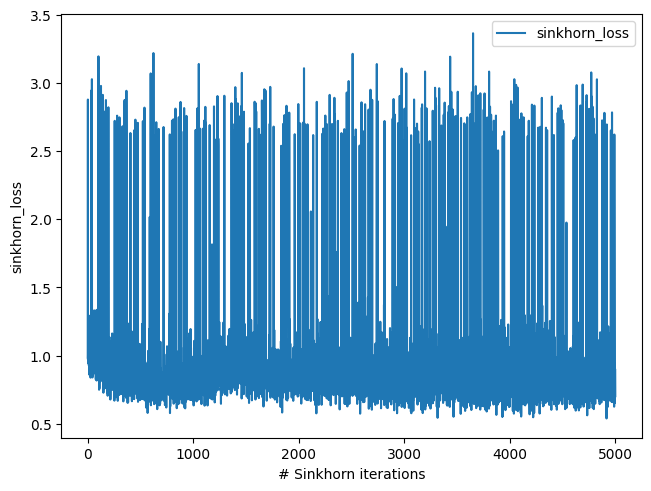

In [ ]:
sinkhorn_loss_mcar25 = torch.tensor(sinkhorn_loss_mcar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mcar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mcar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

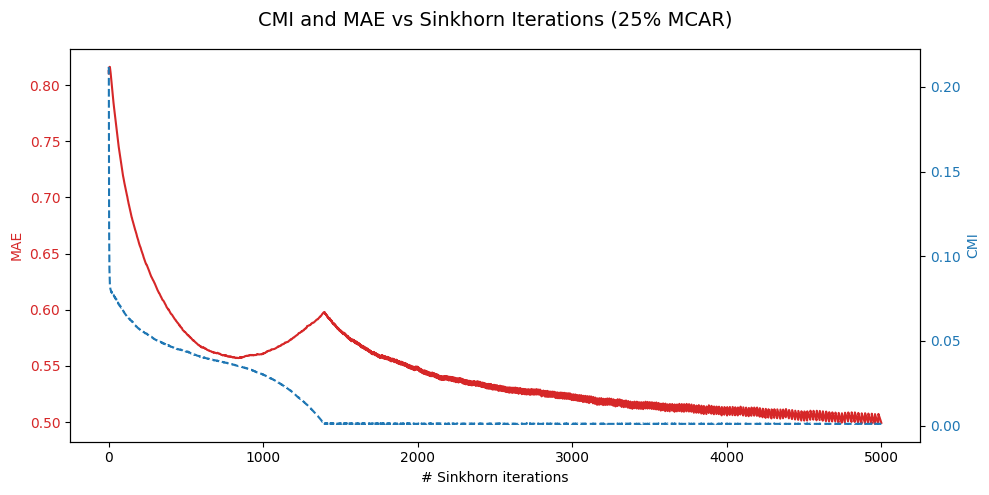

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mcar25
mae_array = sk_maes25mcar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MCAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

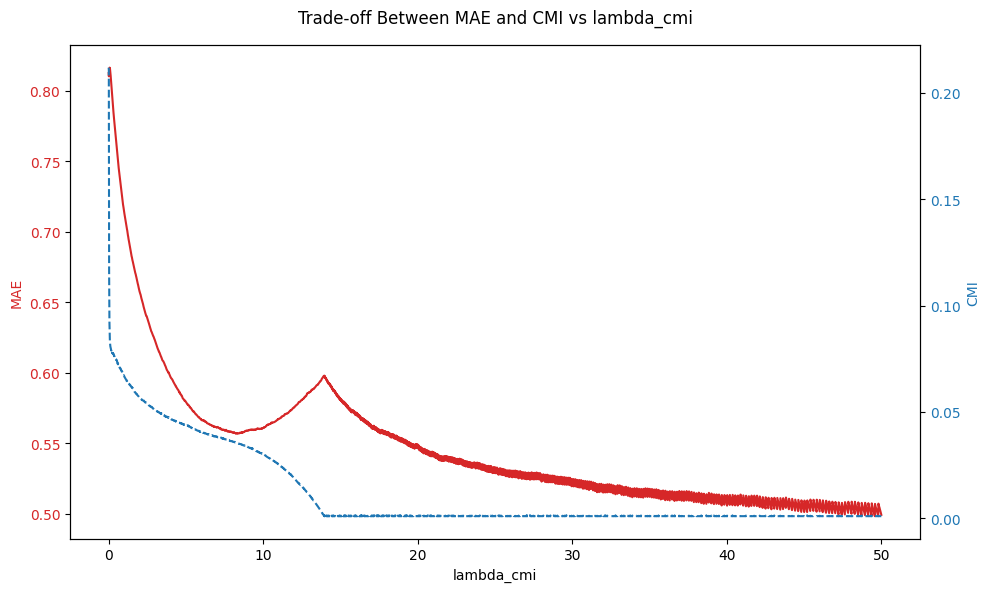

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mcar25 # list of length 2000 from your model
mae_history = sk_maes25mcar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mcar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert to arrays
mae_array_mcar25 = np.array(sk_maes25mcar)
cmi_array_mcar25 = np.array(cmi_loss_mcar25)
lambda_array_mcar25 = np.array(lamda_cmi_mcar25)

# OPTIONAL: Skip very low lambda values (e.g., lambda = 0)
min_index = 10  # or 0 if you want to include everything

# ---- Option 1: Visual Match (Rescale CMI to MAE's range) ----
min_mae_mcar25, max_mae_mcar25 = mae_array_mcar25.min(), mae_array_mcar25.max()
min_cmi_mcar25, max_cmi_mcar25 = cmi_array_mcar25.min(), cmi_array_mcar25.max()

# Rescale CMI to the MAE axis range
cmi_rescaled_mcar25 = (cmi_array_mcar25 - min_cmi_mcar25) / (max_cmi_mcar25 - min_cmi_mcar25) * (max_mae_mcar25 - min_mae_mcar25) + min_mae_mcar25

# Compute difference between MAE and rescaled CMI
diff_mcar25 = np.abs(mae_array_mcar25[min_index:] - cmi_rescaled_mcar25[min_index:])
intersection_idx_mcar25 = np.argmin(diff_mcar25) + min_index  # add offset

# ---- Extract Values at Intersection ----
lambda_intersection_mcra25 = lambda_array_mcar25[intersection_idx_mcar25]
mae_val_mcar25 = mae_array_mcar25[intersection_idx_mcar25]
cmi_val_mcar25 = cmi_array_mcar25[intersection_idx_mcar25]

# ---- Display Result ----
print("Estimated Visual Intersection Point MCAR25:")
print(f"  lambda_cmi_mcar25 = {lambda_intersection_mcra25:.4f}")
print(f"  MAE_mcar25        = {mae_val_mcar25:.4f}")
print(f"  CMI_mcar25        = {cmi_val_mcar25:.4f}")


Estimated Visual Intersection Point MCAR25:
  lambda_cmi_mcar25 = 49.3600
  MAE_mcar25        = 0.4987
  CMI_mcar25        = 0.0012


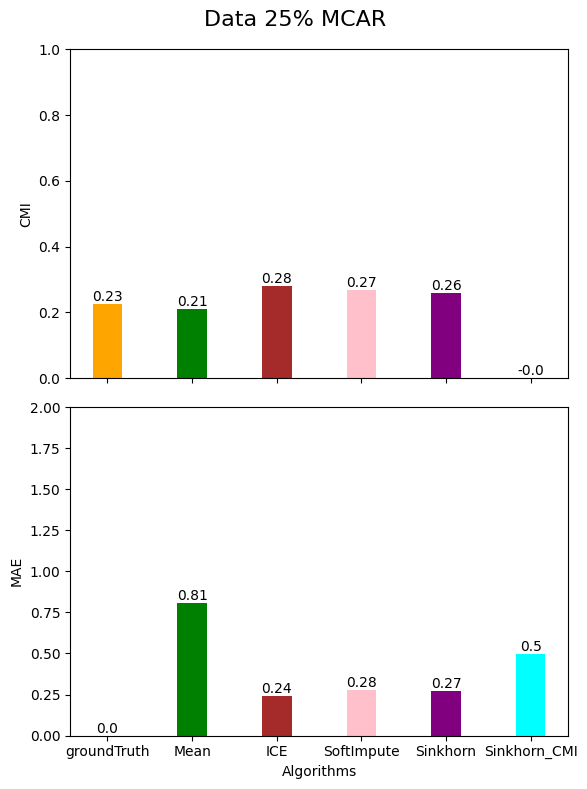

In [ ]:

# Define values and categories
values_cmi_mcar25 = [cmi_groundTruth.detach(),cmi_mean_mcar25.detach(),cmi_ice_mcar25.detach(),cmi_soft_mcar25.detach(),on_cmi_missmcar25.detach(),sk_cmi_mcar25.detach()]
values_maes_mcar25 = [0.0,mean_mae_mcar25.detach(),ice_mae_mcar25.detach(), soft_mae_mcar25.detach(),on_sk_mae_mcar25.detach(),sk_mae_mcar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAE bars and add values on top
bars2 = ax2.bar(index, values_maes_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("MAE")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show()


**25% MAR**

In [ ]:
dependencies_mar25 = {
    "Length": {
        "influencers": ["Sex"],
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"]==-1.15434629 else 0.2 
    },
    "Diameter": {
        "influencers": ["Sex"],
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"]== 0.05379815 else 0.2 
    },
    "WholeWeight": {
        "influencers": ["Height"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Height"]>=0.01156 else 0.1
    },
    "VisceraWeight": {
        "influencers": ["Height"],
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Height"]<=0.01156 else 0.2 
    },
    "ShellWeight": {
        "influencers": ["Sex"],
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"]==1.26194258 else 0.2 
    }


} #Sex [-1.15434629  0.05379815  1.26194258], Height 0.011563294395590387

Generating MAR 25%, and added the target coloumn with the 25% missing MAR data

In [ ]:
generator_mar25 = Inject_Missing_Values()
miss_mar25,index_mar25 = generator_mar25.MAR(X,dependencies_mar25,missing_rate=25)
miss_mar25 = pd.concat([miss_mar25, Y], axis=1) #adding the target coloumn

total_missing_percentage_mar25 = miss_mar25.isnull().sum().sum() / miss_mar25.size * 100
print(f"Total Missing Percentage MAR25: {total_missing_percentage_mar25:.2f}%")

Total Missing Percentage MAR25: 22.22%


In [ ]:
missing_percentage = (miss_mar25.isnull().sum() / len(miss_mar25)) * 100
print(missing_percentage)

Sex               0.000000
Length           35.432128
Diameter         35.623653
Height            0.000000
WholeWeight      46.444817
ShuckedWeight     0.000000
VisceraWeight    48.503711
ShellWeight      33.995691
Rings             0.000000
dtype: float64


In [ ]:
miss_mar25_numpy = miss_mar25.to_numpy()
miss_mar25_tensor = torch.tensor(miss_mar25_numpy) #converting to tensor

In [ ]:
print(miss_mar25.head(5))

        Sex    Length  Diameter    Height  WholeWeight  ShuckedWeight  \
0 -1.154346       NaN       NaN -1.064424    -0.641898      -0.607685   
1 -1.154346       NaN -1.439929 -1.183978    -1.230277      -1.170910   
2  0.053798  0.050033       NaN -0.107991    -0.309469      -0.463500   
3 -1.154346       NaN -0.432149 -0.347099          NaN      -0.648238   
4  1.261943 -1.615544       NaN -1.423087    -1.272086      -1.215968   

   VisceraWeight  ShellWeight     Rings  
0            NaN    -0.638217  1.571544  
1            NaN    -1.212987 -0.910013  
2            NaN          NaN -0.289624  
3            NaN    -0.602294  0.020571  
4      -1.287337          NaN -0.910013  


Applying Sinkhorn algorithm to MAR 25% data

In [ ]:
#only Sinkhorn
n_mar25, d_mar25 = miss_mar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar25 = pick_epsilon(miss_mar25_tensor)
print(epsilon_mar25)
mask_mar25= torch.isnan(miss_mar25_tensor).double()


on_sk_imputer_mar25 = SinkhornImputation(eps=epsilon_mar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mar25, on_sk_maes25mar, on_sk_rmses25mar = on_sk_imputer_mar25.fit_transform(miss_mar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mar25_numpy = on_sk_imp_mar25.detach().cpu().numpy()
on_sk_mae_mar25 = MAE(on_sk_imp_mar25,groundTruth_tensor , mask_mar25)
on_sk_rmse_mar25 = RMSE(on_sk_imp_mar25, groundTruth_tensor, mask_mar25)
print("MAE:",on_sk_mae_mar25)

INFO:root:batchsize = 128, epsilon = 0.2406


0.24055949457462208


INFO:root:Iteration 0:	 Loss: 0.9572	 Validation MAE: 0.8633	RMSE: 1.0614
INFO:root:Iteration 50:	 Loss: 0.7598	 Validation MAE: 0.7802	RMSE: 0.9870
INFO:root:Iteration 100:	 Loss: 0.9148	 Validation MAE: 0.7210	RMSE: 0.9308
INFO:root:Iteration 150:	 Loss: 2.6674	 Validation MAE: 0.6732	RMSE: 0.8847
INFO:root:Iteration 200:	 Loss: 0.7594	 Validation MAE: 0.6309	RMSE: 0.8428
INFO:root:Iteration 250:	 Loss: 0.9365	 Validation MAE: 0.5931	RMSE: 0.8051
INFO:root:Iteration 300:	 Loss: 0.8132	 Validation MAE: 0.5586	RMSE: 0.7708
INFO:root:Iteration 350:	 Loss: 0.6062	 Validation MAE: 0.5254	RMSE: 0.7377
INFO:root:Iteration 400:	 Loss: 0.6110	 Validation MAE: 0.4955	RMSE: 0.7063
INFO:root:Iteration 450:	 Loss: 0.6550	 Validation MAE: 0.4695	RMSE: 0.6762
INFO:root:Iteration 500:	 Loss: 0.7066	 Validation MAE: 0.4434	RMSE: 0.6480
INFO:root:Iteration 550:	 Loss: 0.5018	 Validation MAE: 0.4211	RMSE: 0.6218
INFO:root:Iteration 600:	 Loss: 0.7856	 Validation MAE: 0.4003	RMSE: 0.5969
INFO:root:Itera

CMI for Sinkhorn Imputation

In [ ]:
#only CMI
on_cmi_missmar25 = CMI.c_m_i(on_sk_imp_mar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",on_cmi_missmar25)
print("MAE:",on_sk_mae_mar25)

H(X|Z): 0.6019966919850646, H(Y|Z): 0.913490856110065, H(X,Y|Z): 1.2974559038152718
CMI: tensor(0.2180, grad_fn=<SubBackward0>)
MAE: tensor(0.1856, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MAR 25% data

In [ ]:
#sinkhorn_CMI
n_mar25, d_mar25 = miss_mar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar25 = pick_epsilon(miss_mar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mar25)
mask_mar25 = torch.isnan(miss_mar25_tensor).double()



sk_imputer_mar25 = SinkhornImputation_CMI(eps=epsilon_mar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi = 500)
sk_imp_mar25, sk_maes25mar, sk_rmses25mar,cmi_loss_mar25,sinkhorn_loss_mar25,lamda_cmi_mar25 = sk_imputer_mar25.fit_transform(miss_mar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mar25_numpy = sk_imp_mar25.detach().cpu().numpy()

sk_mae_mar25 = MAE(sk_imp_mar25,groundTruth_tensor , mask_mar25)
sk_rmse_mar25 = RMSE(sk_imp_mar25, groundTruth_tensor, mask_mar25)
print("MAE:",sk_mae_mar25)


0.23618231485732585


INFO:root:Iteration 0:	 Loss: 0.9045	 Validation MAE: 0.8650	RMSE: 1.0631
INFO:root:Iteration 50:	 Loss: 1.0721	 Validation MAE: 0.8125	RMSE: 1.0129
INFO:root:Iteration 100:	 Loss: 0.8146	 Validation MAE: 0.7635	RMSE: 0.9623
INFO:root:Iteration 150:	 Loss: 1.0407	 Validation MAE: 0.7280	RMSE: 0.9245
INFO:root:Iteration 200:	 Loss: 0.8080	 Validation MAE: 0.7004	RMSE: 0.8934
INFO:root:Iteration 250:	 Loss: 0.8633	 Validation MAE: 0.6780	RMSE: 0.8686
INFO:root:Iteration 300:	 Loss: 2.8148	 Validation MAE: 0.6573	RMSE: 0.8456
INFO:root:Iteration 350:	 Loss: 0.8841	 Validation MAE: 0.6395	RMSE: 0.8262
INFO:root:Iteration 400:	 Loss: 0.9547	 Validation MAE: 0.6234	RMSE: 0.8078
INFO:root:Iteration 450:	 Loss: 1.0483	 Validation MAE: 0.6102	RMSE: 0.7919
INFO:root:Iteration 500:	 Loss: 1.0729	 Validation MAE: 0.5980	RMSE: 0.7782
INFO:root:Iteration 550:	 Loss: 1.0647	 Validation MAE: 0.5857	RMSE: 0.7649
INFO:root:Iteration 600:	 Loss: 1.1209	 Validation MAE: 0.5750	RMSE: 0.7534
INFO:root:Itera

MAE: tensor(0.5299, grad_fn=<DivBackward0>)


CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
cmi_mar25 = CMI.c_m_i(sk_imp_mar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mar25)
print("MAE:",sk_mae_mar25)

H(X|Z): 0.17891425431853847, H(Y|Z): 0.37877506553765805, H(X,Y|Z): 0.5244400575924768
CMI: tensor(0.0332, grad_fn=<SubBackward0>)
MAE: tensor(0.5299, grad_fn=<DivBackward0>)


Mean Imputation, CMI and MAE

In [ ]:

mean_imp_mar25 = SimpleImputer().fit_transform(miss_mar25_tensor)
mean_imp_mar25_torch = torch.tensor(mean_imp_mar25)
mean_mae_mar25 = MAE(mean_imp_mar25_torch, groundTruth_tensor , mask_mar25)

print("MAE:",mean_mae_mar25)

cmi_mean_mar25 = CMI.c_m_i(mean_imp_mar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mean_mar25)

MAE: tensor(0.8619, grad_fn=<DivBackward0>)
H(X|Z): 0.3981846630713104, H(Y|Z): 0.6344978107725057, H(X,Y|Z): 0.830760274780971
CMI: tensor(0.2019, grad_fn=<SubBackward0>)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mar25_tensor)
ice_imp_mar25_torch = torch.tensor(ice_imp_mar25)
ice_mae_mar25 = MAE(ice_imp_mar25_torch, groundTruth_tensor , mask_mar25)
print("MAE:",ice_mae_mar25)

cmi_ice_mar25 = CMI.c_m_i(ice_imp_mar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_ice_mar25)

MAE: tensor(0.1611, grad_fn=<DivBackward0>)
H(X|Z): 0.6096219436828543, H(Y|Z): 0.9146056643839691, H(X,Y|Z): 1.3011160777864568
CMI: tensor(0.2231, grad_fn=<SubBackward0>)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mar25, grid_lambda_mar25 = cv_softimpute(miss_mar25_numpy, grid_len=15)
lbda_mar25 = grid_lambda_mar25[np.argmin(cv_error_mar25)]
soft_imp_mar25 = softimpute((miss_mar25_numpy), lbda_mar25)[1]
soft_imp_mar25_torch = torch.tensor(soft_imp_mar25)

soft_mae_mar25 = MAE(soft_imp_mar25_torch, groundTruth_tensor , mask_mar25)
print("MAE:",soft_mae_mar25)

cmi_soft_mar25 = CMI.c_m_i(soft_imp_mar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_soft_mar25)

MAE: tensor(0.1924, grad_fn=<DivBackward0>)
H(X|Z): 0.5904155205933064, H(Y|Z): 0.9055307010445315, H(X,Y|Z): 1.2746895544376082
CMI: tensor(0.2213, grad_fn=<SubBackward0>)


### Visualization

Sinkhorn loss vs Sinkhorn Iterations

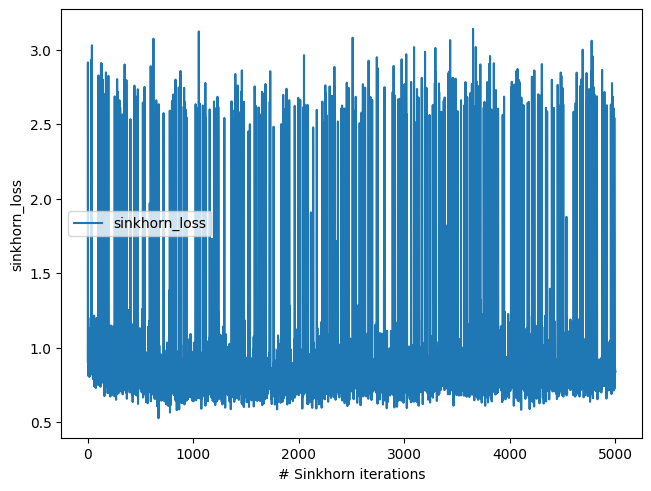

In [ ]:
sinkhorn_loss_mar25 = torch.tensor(sinkhorn_loss_mar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

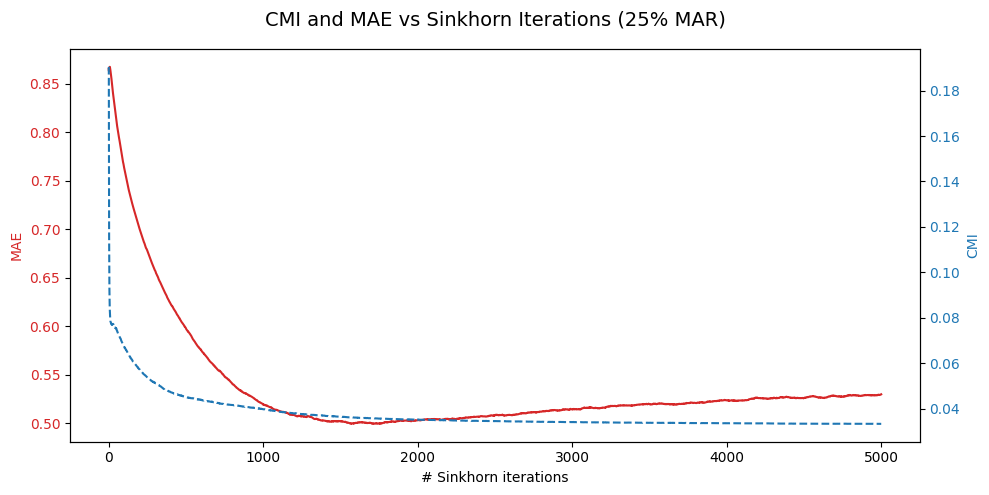

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mar25
mae_array = sk_maes25mar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

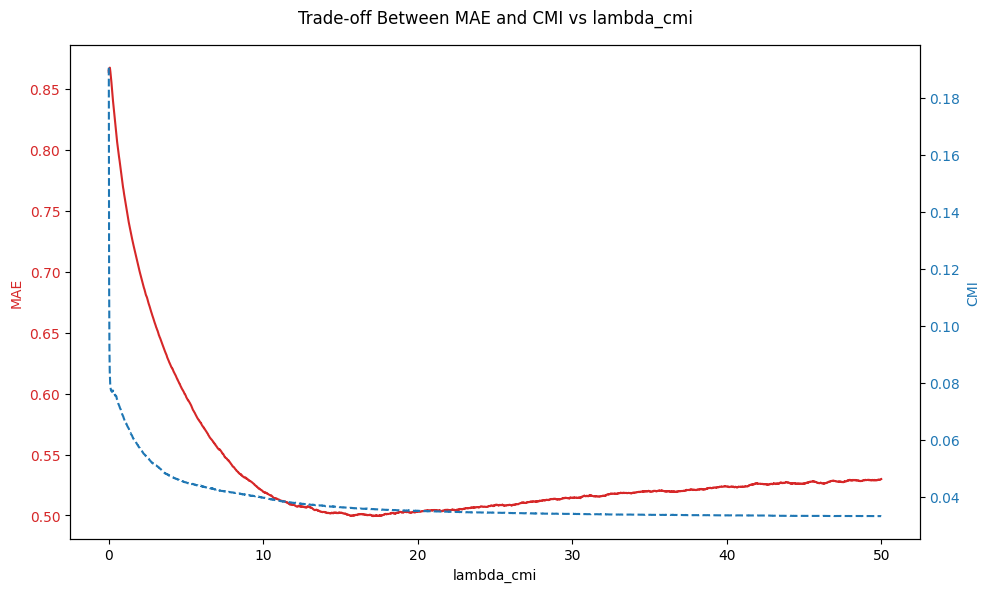

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mar25 # list of length 2000 from your model
mae_history = sk_maes25mar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


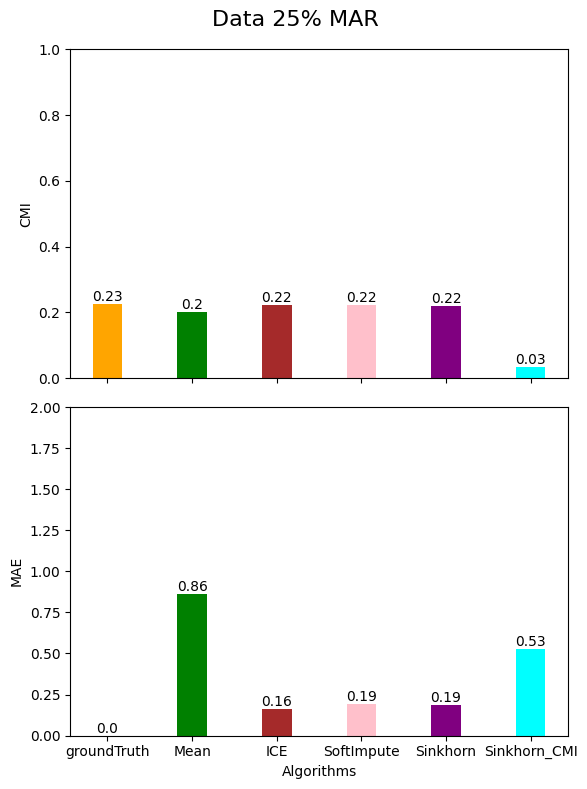

In [ ]:

# Define values and categories
values_cmi_mar25 = [cmi_groundTruth.detach(),cmi_mean_mar25.detach(),cmi_ice_mar25.detach(),cmi_soft_mar25.detach(),on_cmi_missmar25.detach(),cmi_mar25.detach()]
values_maes_mar25 = [0.0,mean_mae_mar25.detach(),ice_mae_mar25.detach(), soft_mae_mar25.detach(),on_sk_mae_mar25.detach(),sk_mae_mar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAE bars and add values on top
bars2 = ax2.bar(index, values_maes_mar25, color=colors, width=bar_width)
ax2.set_ylabel("MAE")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show() #display 


**25% MNAR**

In [ ]:
mean_height = groundTruth_scaled["Height"].mean()
mean_length = groundTruth_scaled["Length"].mean()
median_diameter = groundTruth_scaled["Diameter"].median()
median_wholeWeigh = groundTruth_scaled["WholeWeight"].median()
median_visceraWeight = groundTruth_scaled["VisceraWeight"].median()
mean_ShellWeight = groundTruth_scaled["ShellWeight"].mean()



dependencies_mnar25 = {
    "Length": {
        
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Length"] <= mean_length else 0.2 
    },
    "Diameter": {
       
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Diameter"] <= median_diameter else 0.2 
    },
    "WholeWeight": {
        
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["WholeWeight"] < median_wholeWeigh else 0.1
    },
    "VisceraWeight": {
        
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["VisceraWeight"] > median_visceraWeight else 0.2 
    },
    "ShellWeight": {
        
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["ShellWeight"] > mean_ShellWeight else 0.2 
    },
    "Height": {
        
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Height"] > mean_height else 0.2 
    },
    "Sex": {
        
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"]==0.05379815 else 0.2 
    }


}

Generating MNAR 25%, and added the target coloumn with the 25% missing MNAR data

In [ ]:
generator_mnar25 = Inject_Missing_Values()
miss_mnar25,index_mnar25 = generator_mnar25.MNAR(X,dependencies_mnar25,missing_rate=25)

miss_mnar25 = pd.concat([miss_mnar25, Y], axis=1) #adding the target coloumn

total_missing_percentage_mnar25 = miss_mnar25.isnull().sum().sum() / miss_mnar25.size * 100
print(f"Total Missing Percentage MNAR25: {total_missing_percentage_mnar25:.2f}%")

Total Missing Percentage MNAR25: 22.22%


In [ ]:
missing_percentage = (miss_mnar25.isnull().sum() / len(miss_mnar25)) * 100
print(missing_percentage)

Sex              18.984917
Length           30.165190
Diameter         31.625569
Height           31.290400
WholeWeight      26.598037
ShuckedWeight     0.000000
VisceraWeight    31.027053
ShellWeight      30.308834
Rings             0.000000
dtype: float64


In [ ]:
miss_mnar25_numpy = miss_mnar25.to_numpy()
miss_mnar25_tensor = torch.tensor(miss_mnar25_numpy) #converting to tensor

Applying Sinkhorn algorithm to MNAR 25% data

In [ ]:
#only Sinkhorn
n_mnar25, d_mnar25 = miss_mnar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar25 = pick_epsilon(miss_mnar25_tensor)
print(epsilon_mnar25)
mask_mnar25= torch.isnan(miss_mnar25_tensor).double()


on_sk_imputer_mnar25 = SinkhornImputation(eps=epsilon_mnar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mnar25, on_sk_maes25mnar, on_sk_rmses25mnar = on_sk_imputer_mnar25.fit_transform(miss_mnar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mnar25_numpy = on_sk_imp_mnar25.detach().cpu().numpy()
on_sk_mae_mnar25 = MAE(on_sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
on_sk_rmse_mnar25 = RMSE(on_sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
print("MAE:",on_sk_mae_mnar25)

INFO:root:batchsize = 128, epsilon = 0.2301
INFO:root:Iteration 0:	 Loss: 0.9711	 Validation MAE: 0.8707	RMSE: 1.0948


0.23007461772239465


INFO:root:Iteration 50:	 Loss: 0.7865	 Validation MAE: 0.7899	RMSE: 1.0248
INFO:root:Iteration 100:	 Loss: 0.9244	 Validation MAE: 0.7314	RMSE: 0.9716
INFO:root:Iteration 150:	 Loss: 0.7201	 Validation MAE: 0.6850	RMSE: 0.9291
INFO:root:Iteration 200:	 Loss: 0.7945	 Validation MAE: 0.6447	RMSE: 0.8923
INFO:root:Iteration 250:	 Loss: 0.9485	 Validation MAE: 0.6095	RMSE: 0.8592
INFO:root:Iteration 300:	 Loss: 0.6721	 Validation MAE: 0.5768	RMSE: 0.8278
INFO:root:Iteration 350:	 Loss: 0.5422	 Validation MAE: 0.5463	RMSE: 0.7992
INFO:root:Iteration 400:	 Loss: 0.5938	 Validation MAE: 0.5193	RMSE: 0.7732
INFO:root:Iteration 450:	 Loss: 0.6365	 Validation MAE: 0.4953	RMSE: 0.7491
INFO:root:Iteration 500:	 Loss: 0.7014	 Validation MAE: 0.4742	RMSE: 0.7275
INFO:root:Iteration 550:	 Loss: 0.5279	 Validation MAE: 0.4540	RMSE: 0.7065
INFO:root:Iteration 600:	 Loss: 0.7631	 Validation MAE: 0.4355	RMSE: 0.6858
INFO:root:Iteration 650:	 Loss: 0.7131	 Validation MAE: 0.4183	RMSE: 0.6671
INFO:root:Ite

MAE: tensor(0.2634, grad_fn=<DivBackward0>)


CMI for Sinkhorn Imputation

In [ ]:
#only CMI
on_cmi_missmnar25 = CMI.c_m_i(on_sk_imp_mnar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",on_cmi_missmnar25)
print("MAE:",on_sk_mae_mnar25)

H(X|Z): 0.7208858577214867, H(Y|Z): 0.9339232872366763, H(X,Y|Z): 1.4038350579048053
CMI: tensor(0.2510, grad_fn=<SubBackward0>)
MAE: tensor(0.2634, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MNAR 25% data

In [ ]:
#sinkhorn_CMI
n_mnar25, d_mnar25 = miss_mnar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar25 = pick_epsilon(miss_mnar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mnar25)
mask_mnar25 = torch.isnan(miss_mnar25_tensor).double()


sk_imputer_mnar25 = SinkhornImputation_CMI(eps = epsilon_mnar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi=500)
sk_imp_mnar25, sk_maes25mnar, sk_rmses25mnar,cmi_loss_mnar25, sinkhorn_loss_mnar25, lamda_cmi_mnar25 = sk_imputer_mnar25.fit_transform(miss_mnar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mnar25_numpy = sk_imp_mnar25.detach().cpu().numpy()

sk_mae_mnar25 = MAE(sk_imp_mnar25, groundTruth_tensor , mask_mnar25)
sk_rmse_mnar25 = RMSE(sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
print("MAE:",sk_mae_mnar25)





0.2313821703164512


INFO:root:Iteration 0:	 Loss: 0.9551	 Validation MAE: 0.8721	RMSE: 1.0955
INFO:root:Iteration 50:	 Loss: 0.9772	 Validation MAE: 0.8173	RMSE: 1.0488
INFO:root:Iteration 100:	 Loss: 0.8039	 Validation MAE: 0.7715	RMSE: 1.0037
INFO:root:Iteration 150:	 Loss: 1.0269	 Validation MAE: 0.7400	RMSE: 0.9702
INFO:root:Iteration 200:	 Loss: 0.7860	 Validation MAE: 0.7154	RMSE: 0.9446
INFO:root:Iteration 250:	 Loss: 0.8306	 Validation MAE: 0.6969	RMSE: 0.9246
INFO:root:Iteration 300:	 Loss: 1.0027	 Validation MAE: 0.6793	RMSE: 0.9068
INFO:root:Iteration 350:	 Loss: 0.8694	 Validation MAE: 0.6646	RMSE: 0.8924
INFO:root:Iteration 400:	 Loss: 0.8584	 Validation MAE: 0.6508	RMSE: 0.8791
INFO:root:Iteration 450:	 Loss: 0.9589	 Validation MAE: 0.6392	RMSE: 0.8680
INFO:root:Iteration 500:	 Loss: 1.0048	 Validation MAE: 0.6291	RMSE: 0.8595
INFO:root:Iteration 550:	 Loss: 0.9042	 Validation MAE: 0.6205	RMSE: 0.8520
INFO:root:Iteration 600:	 Loss: 1.0106	 Validation MAE: 0.6130	RMSE: 0.8466
INFO:root:Itera

CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
cmi_mnar25 = CMI.c_m_i(sk_imp_mnar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mnar25)
print("MAE:",sk_mae_mnar25)

CMI: tensor(0.0001, grad_fn=<ClampBackward1>)
MAE: tensor(0.6943, grad_fn=<DivBackward0>)


Mean Imputation, CMI and MAE

In [ ]:

mean_imp_mnar25 = SimpleImputer().fit_transform(miss_mnar25_tensor)
mean_imp_mnar25_torch = torch.tensor(mean_imp_mnar25)
mean_mae_mnar25 = MAE(mean_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)

print("MAE:",mean_mae_mnar25)

cmi_mean_mnar25 = CMI.c_m_i(mean_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mean_mnar25)

MAE: tensor(0.7653, grad_fn=<DivBackward0>)
CMI: tensor(0.2193, grad_fn=<ClampBackward1>)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mnar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mnar25_tensor)
ice_imp_mnar25_torch = torch.tensor(ice_imp_mnar25)
ice_mae_mnar25 = MAE(ice_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)
print("MAE:",ice_mae_mnar25)

cmi_ice_mnar25 = CMI.c_m_i(ice_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_ice_mnar25)

MAE: tensor(0.7967, grad_fn=<DivBackward0>)
CMI: tensor(0.2532, grad_fn=<ClampBackward1>)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mnar25, grid_lambda_mnar25 = cv_softimpute(miss_mnar25_numpy, grid_len=15)
lbda_mnar25 = grid_lambda_mnar25[np.argmin(cv_error_mnar25)]
soft_imp_mnar25 = softimpute((miss_mnar25_numpy), lbda_mnar25)[1]
soft_imp_mnar25_torch = torch.tensor(soft_imp_mnar25)

soft_mae_mnar25 = MAE(soft_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)
print("MAE:",soft_mae_mnar25)

cmi_soft_mnar25 = CMI.c_m_i(soft_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_soft_mnar25)

MAE: tensor(0.7233, grad_fn=<DivBackward0>)
CMI: tensor(0.2161, grad_fn=<ClampBackward1>)


### Visualization

Sinkhorn loss vs Sinkhorn Interations

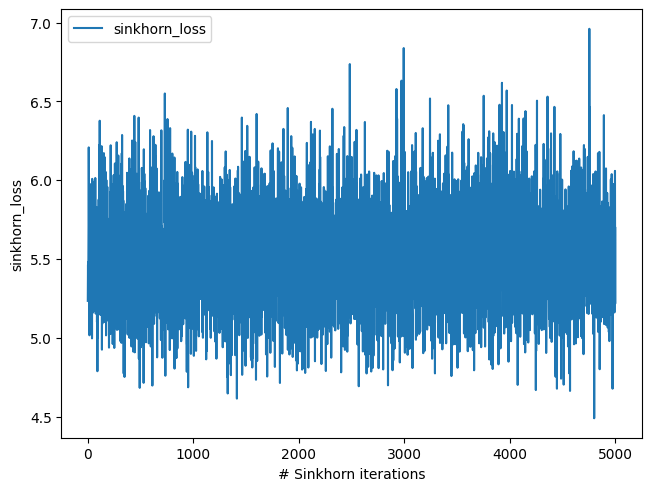

In [ ]:
sinkhorn_loss_mnar25 = torch.tensor(sinkhorn_loss_mnar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mnar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mnar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

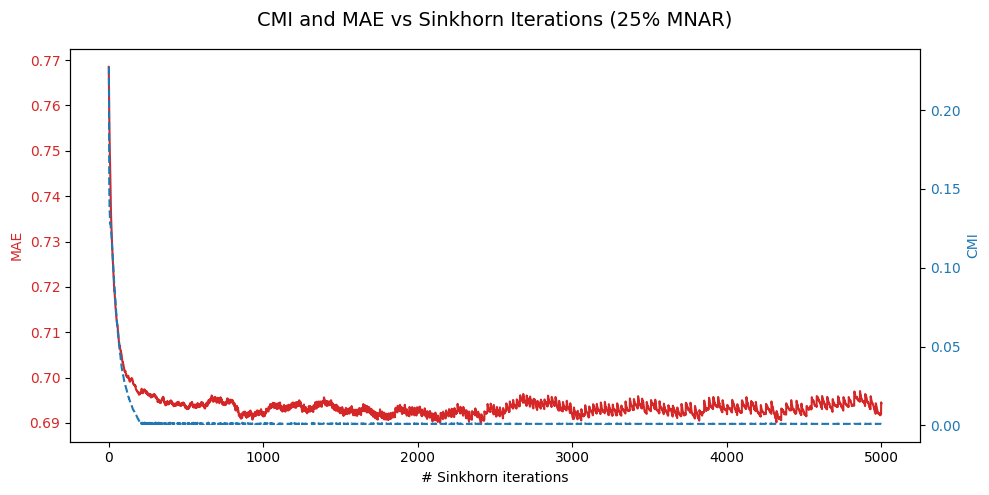

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mnar25
mae_array = sk_maes25mnar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MNAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

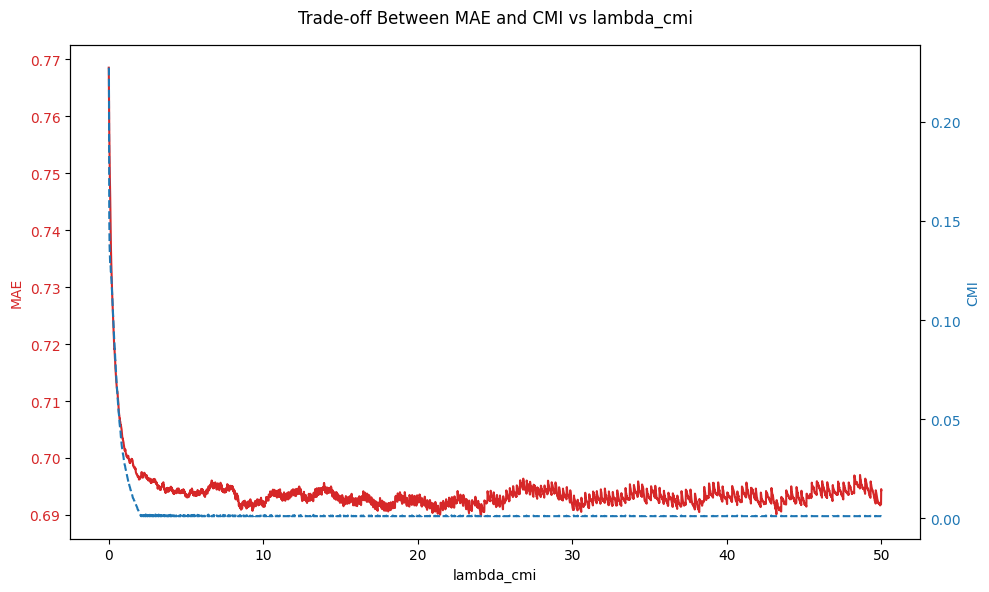

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mnar25 # list of length 2000 from your model
mae_history = sk_maes25mnar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mnar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


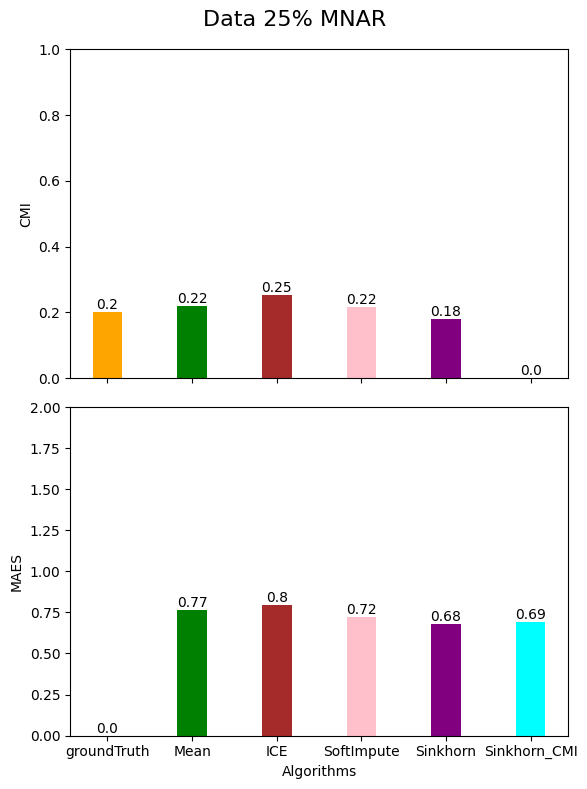

In [ ]:

# Define values and categories
values_cmi_mnar25 = [cmi_groundTruth.detach(),cmi_mean_mnar25.detach(),cmi_ice_mnar25.detach(),cmi_soft_mnar25.detach(),on_cmi_missmnar25.detach(),cmi_mnar25.detach()]
values_maes_mnar25 = [0.0,mean_mae_mnar25.detach(),ice_mae_mnar25.detach(), soft_mae_mnar25.detach(),on_sk_mae_mnar25.detach(),sk_mae_mnar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MNAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mnar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAES bars and add values on top
bars2 = ax2.bar(index, values_maes_mnar25, color=colors, width=bar_width)
ax2.set_ylabel("MAES")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show()


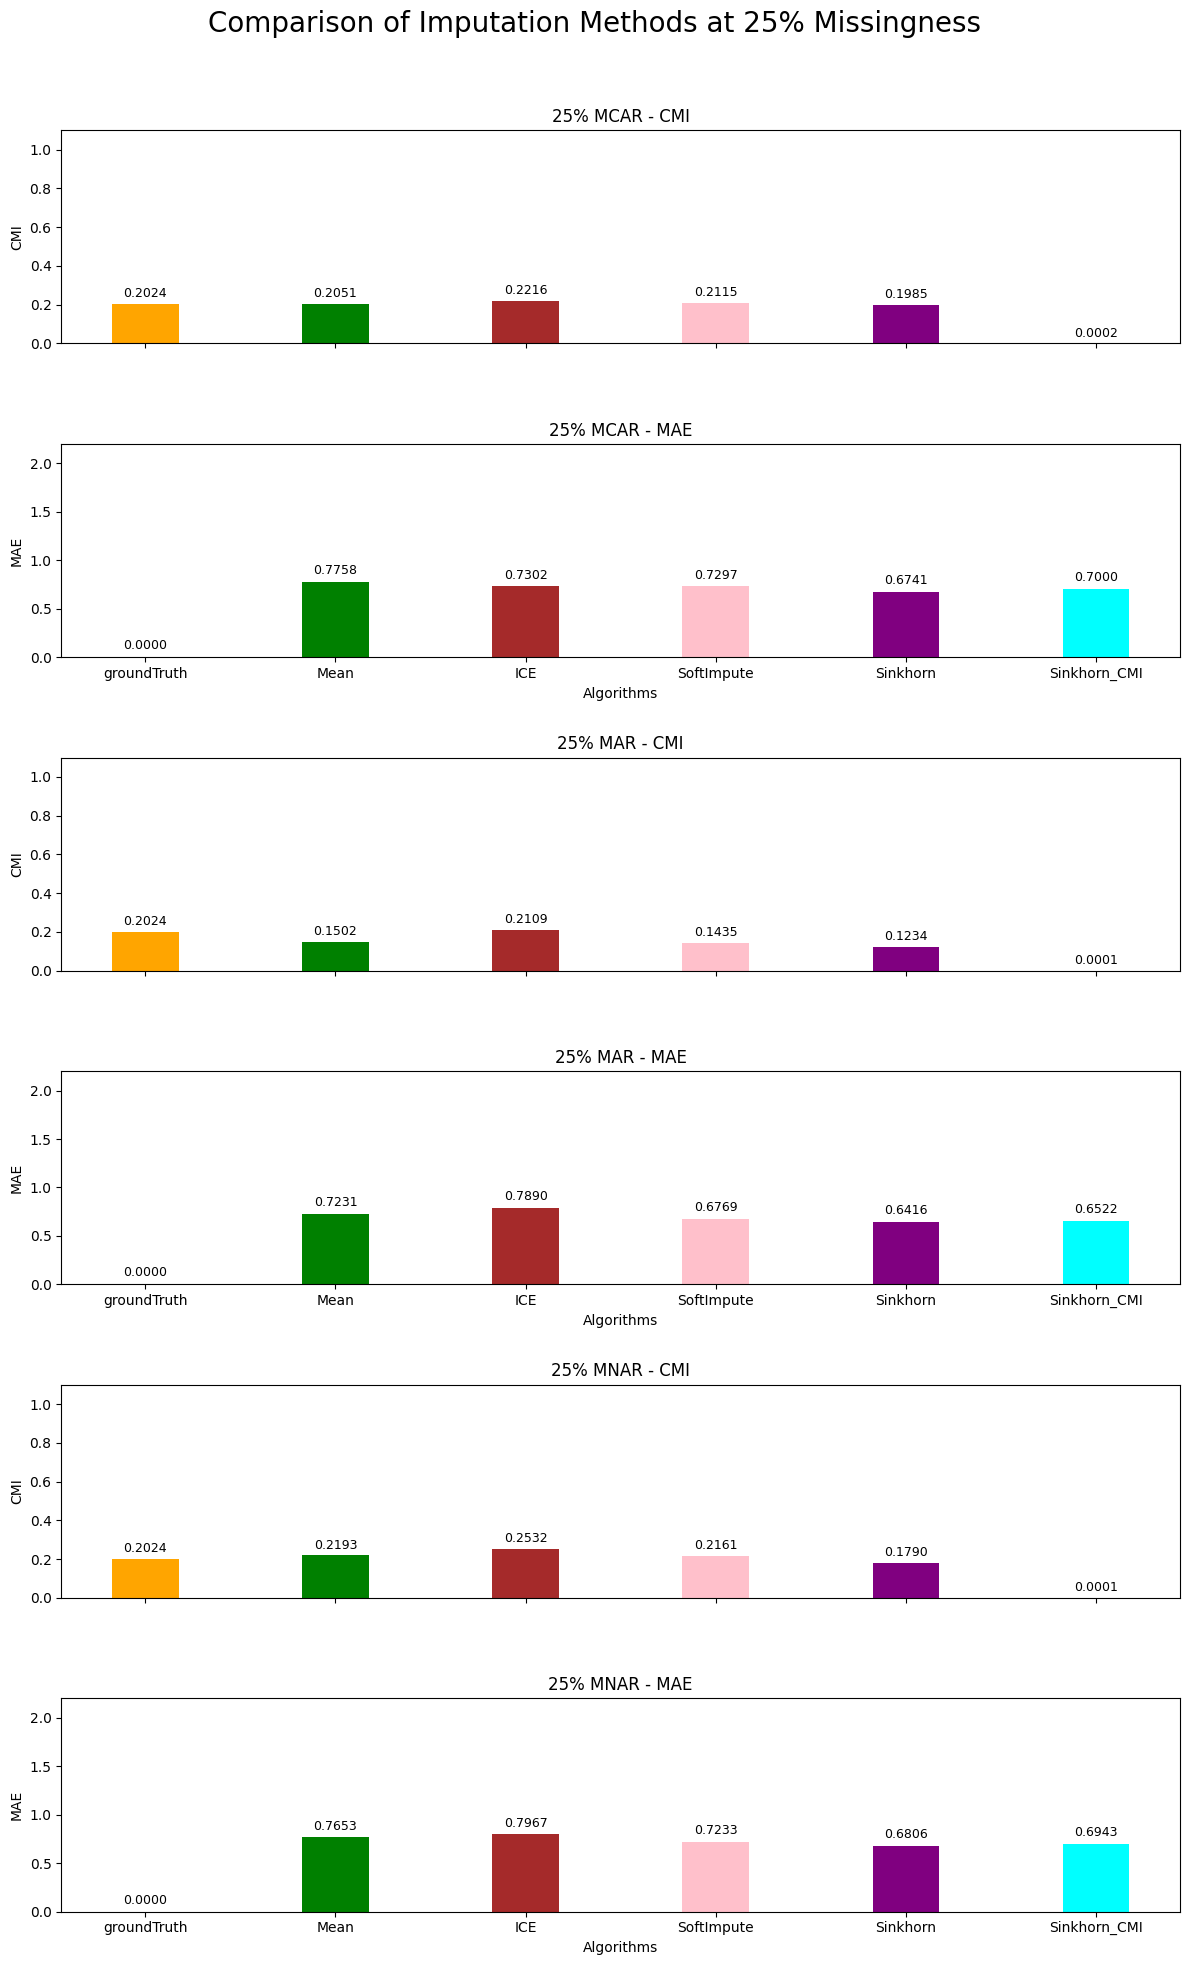

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(12, 20), sharex=False)
fig.suptitle('Comparison of Imputation Methods at 25% Missingness', fontsize=20)

# MCAR, MAR, MNAR order
plot_data = [
    ("25% MCAR", values_cmi_mcar25, values_maes_mcar25),
    ("25% MAR", values_cmi_mar25, values_maes_mar25),
    ("25% MNAR", values_cmi_mnar25, values_maes_mnar25),
]

for i, (title, cmi_vals, mae_vals) in enumerate(plot_data):
    ax_cmi = axes[i * 2]
    ax_mae = axes[i * 2 + 1]

    # ----------------- CMI Plot -----------------
    bars1 = ax_cmi.bar(index, cmi_vals, color=colors, width=bar_width)
    ax_cmi.set_ylabel("CMI")
    ax_cmi.set_ylim(0, 1.1)
    ax_cmi.set_title(f"{title} - CMI")
    for bar in bars1:
        yval = bar.get_height()
        ax_cmi.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

    # Remove x-axis labels and ticks for CMI
    ax_cmi.set_xticks(index)
    ax_cmi.set_xticklabels([])

    # ----------------- MAE Plot -----------------
    bars2 = ax_mae.bar(index, mae_vals, color=colors, width=bar_width)
    ax_mae.set_ylabel("MAE")
    ax_mae.set_ylim(0, 2.2)
    ax_mae.set_title(f"{title} - MAE")
    for bar in bars2:
        yval = bar.get_height()
        ax_mae.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

    ax_mae.set_xticks(index)
    ax_mae.set_xticklabels(categories, fontsize=10, rotation=0)
    ax_mae.set_xlabel("Algorithms")

plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.5)
plt.show()


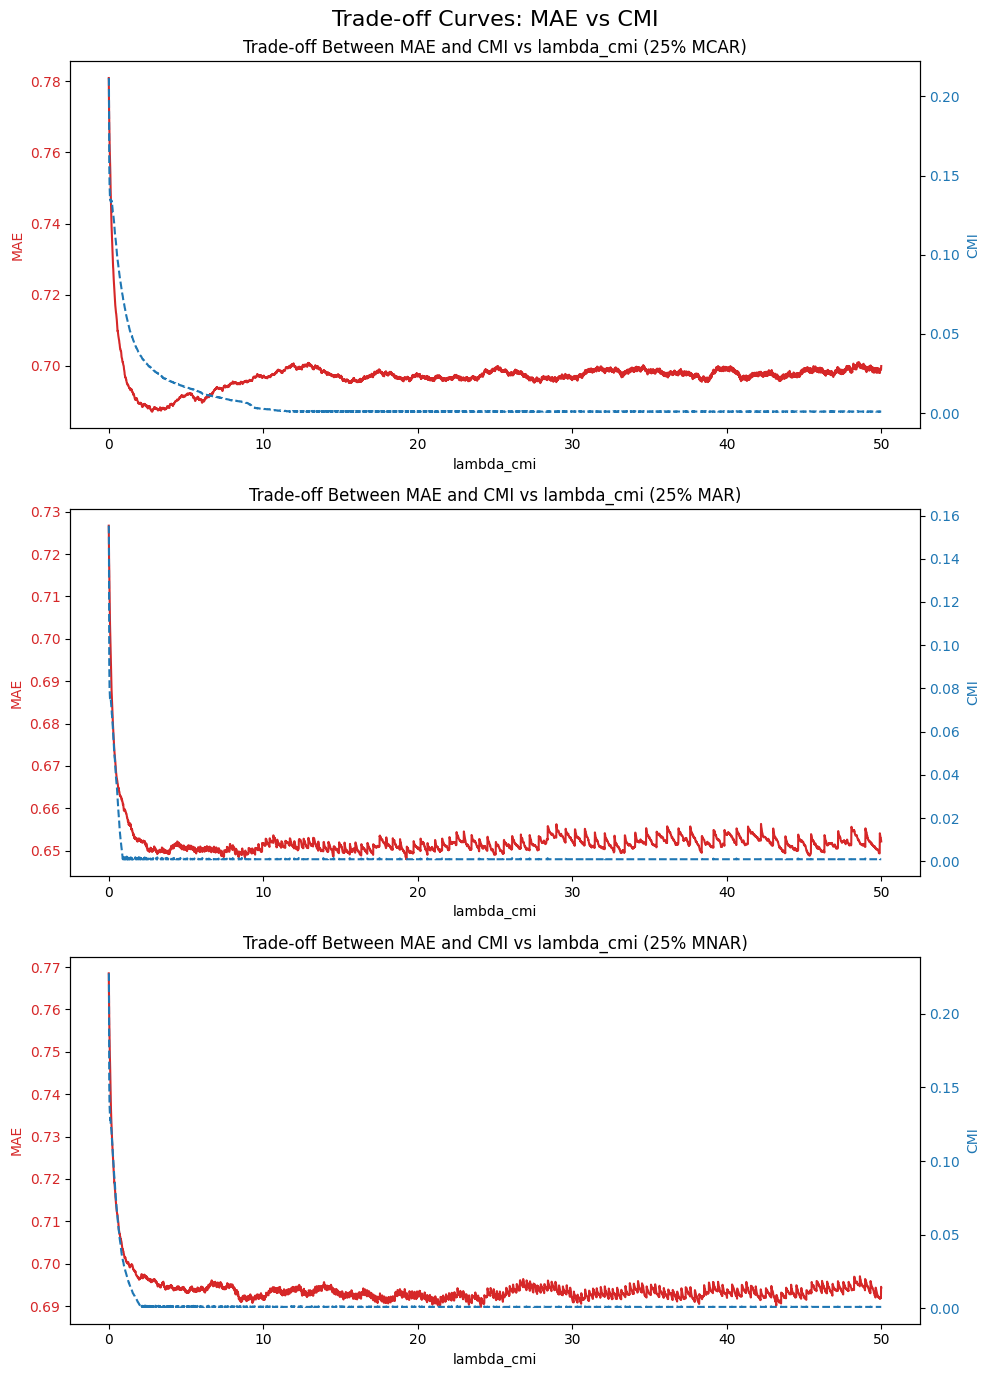

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# New order: MCAR, MAR, MNAR
datasets = [
    ("25% MCAR", lamda_cmi_mcar25, sk_maes25mcar, cmi_loss_mcar25),
    ("25% MAR", lamda_cmi_mar25, sk_maes25mar, cmi_loss_mar25),
    ("25% MNAR", lamda_cmi_mnar25, sk_maes25mnar, cmi_loss_mnar25),
]

for i, (title, lambda_vals, mae_vals, cmi_vals) in enumerate(datasets):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # MAE (left y-axis)
    ax1.set_ylabel('MAE', color='tab:red')
    ax1.plot(lambda_vals, mae_vals, color='tab:red', label='MAE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # CMI (right y-axis)
    ax2.set_ylabel('CMI', color='tab:blue')
    ax2.plot(lambda_vals, cmi_vals, color='tab:blue', linestyle='--', label='CMI')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax1.set_title(f'Trade-off Between MAE and CMI vs lambda_cmi ({title})')
    ax1.set_xlabel('lambda_cmi')

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('Trade-off Curves: MAE vs CMI', fontsize=16)
plt.show()


### Machine Learning

In [ ]:
print(torch.unique(sk_imp_mcar25[:,19]))

tensor([-2.1334e+00, -2.0742e+00, -1.9797e+00, -1.9284e+00, -1.6797e+00,
        -1.6503e+00, -1.6091e+00, -1.5570e+00, -1.5414e+00, -1.5388e+00,
        -1.5357e+00, -1.5329e+00, -1.5240e+00, -1.5238e+00, -1.5237e+00,
        -1.5101e+00, -1.5091e+00, -1.5051e+00, -1.5040e+00, -1.5024e+00,
        -1.5011e+00, -1.4993e+00, -1.4968e+00, -1.4966e+00, -1.4919e+00,
        -1.4905e+00, -1.4785e+00, -1.4565e+00, -1.4552e+00, -1.4481e+00,
        -1.1938e+00, -9.6393e-01, -9.3925e-01, -9.3528e-01, -8.6652e-01,
        -8.6493e-01, -8.4339e-01, -8.4247e-01, -8.3030e-01, -8.0785e-01,
        -8.0206e-01, -7.9629e-01, -7.9386e-01, -7.6682e-01, -7.4356e-01,
        -7.4259e-01, -7.3292e-01, -7.1202e-01, -6.7260e-01, -6.6385e-01,
        -6.5998e-01, -6.5628e-01, -5.5852e-01, -5.4570e-01, -5.1812e-01,
        -4.6758e-01, -4.6344e-01, -3.5985e-01, -3.3475e-01, -3.2601e-01,
        -3.0554e-01, -2.1612e-01, -2.0585e-01, -1.9748e-01, -1.8522e-01,
        -1.5456e-01, -1.2299e-01, -1.2086e-01, -1.1

In [ ]:
print(torch.unique(sk_imp_mnar25[:,19]))

tensor([-1.5181e+00, -1.4962e+00, -1.4919e+00, -1.4911e+00, -1.4649e+00,
        -1.4646e+00, -1.4544e+00, -1.4408e+00, -1.4281e+00, -1.4068e+00,
        -1.4007e+00, -1.3965e+00, -1.3831e+00, -1.3588e+00, -1.2438e+00,
        -1.1943e+00, -1.1900e+00, -1.1670e+00, -1.1532e+00, -1.1218e+00,
        -1.0980e+00, -1.0539e+00, -9.6094e-01, -9.2227e-01, -9.0990e-01,
        -8.4452e-01, -8.3382e-01, -8.1968e-01, -7.9805e-01, -7.7666e-01,
        -7.6536e-01, -7.4968e-01, -7.4664e-01, -7.3814e-01, -7.2390e-01,
        -7.2015e-01, -6.9664e-01, -6.8937e-01, -6.0821e-01, -5.8187e-01,
        -5.5989e-01, -5.5548e-01, -5.5112e-01, -5.4655e-01, -5.3690e-01,
        -5.2957e-01, -5.1063e-01, -5.0495e-01, -4.9104e-01, -4.9036e-01,
        -4.8295e-01, -4.3482e-01, -4.2999e-01, -4.2298e-01, -4.0742e-01,
        -4.0735e-01, -4.0688e-01, -4.0212e-01, -3.9485e-01, -3.9325e-01,
        -3.8323e-01, -3.7359e-01, -3.6117e-01, -3.5813e-01, -3.4423e-01,
        -3.2747e-01, -3.1857e-01, -3.0999e-01, -3.0

In [ ]:
#sex_col = sk_cmi_imp_mcar25[:, 19]
#sex_binary = (sex_col >= 0.5).int()  # or use 0.5 as threshold
#sk_cmi_imp_mcar25[:, 19] = sex_binary


In [ ]:
print(sk_imp_mcar25[:, 19])

tensor([ 5.3073e-01, -1.4919e+00,  6.7028e-01,  6.7028e-01,  7.8911e-01,
         6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,
        -1.4919e+00, -1.4919e+00, -1.4919e+00,  6.7028e-01, -1.4919e+00,
        -1.4919e+00,  7.9910e-01,  6.7028e-01, -1.4919e+00,  6.7028e-01,
         6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,
         4.6136e-02,  7.0672e-01, -1.4919e+00,  6.7028e-01,  6.7028e-01,
         6.7028e-01,  6.7028e-01,  7.4789e-01,  1.7586e-01, -3.3475e-01,
         6.7028e-01, -1.5237e+00,  6.7028e-01,  6.7028e-01,  6.7028e-01,
         6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01, -1.4919e+00,
        -1.4919e+00,  6.7028e-01, -1.9748e-01, -1.6091e+00, -1.4919e+00,
         2.3252e-01,  6.7028e-01,  6.7028e-01, -6.1099e-02,  6.7028e-01,
         6.8118e-01,  6.7028e-01, -1.4919e+00, -6.6385e-01, -1.4919e+00,
         6.6427e-01,  6.7028e-01,  6.1229e-01,  6.7028e-01, -1.4919e+00,
         6.7028e-01, -1.4919e+00,  6.7028e-01,  6.7

In [ ]:
sk_imp_mnar25[:,19]

tensor([ 6.7028e-01, -3.0145e-01,  6.7028e-01,  6.7028e-01,  7.0403e-01,
         6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,
        -1.4919e+00, -1.4919e+00, -1.4919e+00,  6.7028e-01, -1.3588e+00,
        -1.4919e+00,  3.6686e-01,  6.7028e-01, -1.4919e+00,  6.7028e-01,
        -5.0054e-02,  6.7028e-01,  4.4471e-01,  6.7028e-01,  6.7028e-01,
         3.4383e-02,  6.7028e-01,  1.0611e-01,  6.7028e-01,  6.7028e-01,
         7.4920e-01,  6.7028e-01,  6.7028e-01,  9.1380e-02,  5.5354e-02,
         6.7028e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01, -8.1968e-01,
        -7.9278e-02, -3.8323e-01,  6.7028e-01,  6.7028e-01, -1.4919e+00,
        -1.4919e+00,  6.7028e-01, -1.4919e+00,  7.2839e-02, -1.4919e+00,
         6.7028e-01, -5.0495e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01,
         6.7028e-01,  6.7028e-01, -1.4919e+00, -1.4919e+00, -1.4919e+00,
         7.7255e-01,  6.7028e-01,  6.7028e-01,  6.7028e-01, -1.4919e+00,
         4.3364e-01, -1.4919e+00,  6.7028e-01,  6.7

Generating MNAR 25%, and added the target coloumn with the 25% missing MNAR data

In [ ]:
generator_mnar25 = Inject_Missing_Values()
miss_mnar25,index_mnar25 = generator_mnar25.MNAR(X,dependencies_mnar25,missing_rate=25)

miss_mnar25 = pd.concat([miss_mnar25, Y], axis=1) #adding the target coloumn

total_missing_percentage_mnar25 = miss_mnar25.isnull().sum().sum() / miss_mnar25.size * 100
print(f"Total Missing Percentage MNAR25: {total_missing_percentage_mnar25:.2f}%")

IndexError: invalid index to scalar variable.

In [ ]:
missing_percentage = (miss_mnar25.isnull().sum() / len(miss_mnar25)) * 100
print(missing_percentage)

Sex              17.333014
Length           31.242519
Diameter         31.266459
Height           36.940388
WholeWeight      21.594446
ShuckedWeight     0.000000
VisceraWeight    30.380656
ShellWeight      31.242519
Rings             0.000000
dtype: float64


In [ ]:
miss_mnar25_numpy = miss_mnar25.to_numpy()
miss_mnar25_tensor = torch.tensor(miss_mnar25_numpy) #converting to tensor

Applying Sinkhorn algorithm to MNAR 25% data

In [ ]:
#only Sinkhorn
n_mnar25, d_mnar25 = miss_mnar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar25 = pick_epsilon(miss_mnar25_tensor)
print(epsilon_mnar25)
mask_mnar25= torch.isnan(miss_mnar25_tensor).double()


on_sk_imputer_mnar25 = SinkhornImputation(eps=epsilon_mnar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mnar25, on_sk_maes25mnar, on_sk_rmses25mnar = on_sk_imputer_mnar25.fit_transform(miss_mnar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mnar25_numpy = on_sk_imp_mnar25.detach().cpu().numpy()
on_sk_mae_mnar25 = MAE(on_sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
on_sk_rmse_mnar25 = RMSE(on_sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
print("MAE:",on_sk_mae_mnar25)

INFO:root:batchsize = 128, epsilon = 0.2390
INFO:root:Iteration 0:	 Loss: 0.9268	 Validation MAE: 0.8111	RMSE: 1.0088


0.2389625661238545


INFO:root:Iteration 50:	 Loss: 0.8496	 Validation MAE: 0.7296	RMSE: 0.9330


INFO:root:Iteration 100:	 Loss: 0.9731	 Validation MAE: 0.6743	RMSE: 0.8779
INFO:root:Iteration 150:	 Loss: 2.6927	 Validation MAE: 0.6317	RMSE: 0.8351
INFO:root:Iteration 200:	 Loss: 0.7718	 Validation MAE: 0.5947	RMSE: 0.7978
INFO:root:Iteration 250:	 Loss: 1.0226	 Validation MAE: 0.5612	RMSE: 0.7622
INFO:root:Iteration 300:	 Loss: 0.6876	 Validation MAE: 0.5308	RMSE: 0.7301
INFO:root:Iteration 350:	 Loss: 0.5918	 Validation MAE: 0.5017	RMSE: 0.7006
INFO:root:Iteration 400:	 Loss: 0.6529	 Validation MAE: 0.4768	RMSE: 0.6739
INFO:root:Iteration 450:	 Loss: 0.6521	 Validation MAE: 0.4537	RMSE: 0.6479
INFO:root:Iteration 500:	 Loss: 0.7134	 Validation MAE: 0.4332	RMSE: 0.6253
INFO:root:Iteration 550:	 Loss: 0.4788	 Validation MAE: 0.4142	RMSE: 0.6037
INFO:root:Iteration 600:	 Loss: 0.7854	 Validation MAE: 0.3964	RMSE: 0.5827
INFO:root:Iteration 650:	 Loss: 0.7085	 Validation MAE: 0.3802	RMSE: 0.5639
INFO:root:Iteration 700:	 Loss: 0.5890	 Validation MAE: 0.3653	RMSE: 0.5469
INFO:root:It

MAE: tensor(0.2468, grad_fn=<DivBackward0>)


CMI for Sinkhorn Imputation

In [ ]:
#only CMI
on_cmi_missmnar25 = CMI.c_m_i(on_sk_imp_mnar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",on_cmi_missmnar25)
print("MAE:",on_sk_mae_mnar25)

CMI: tensor(0.)
MAE: tensor(0.2468, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MNAR 25% data

In [ ]:
#sinkhorn_CMI
n_mnar25, d_mnar25 = miss_mnar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar25 = pick_epsilon(miss_mnar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mnar25)
mask_mnar25 = torch.isnan(miss_mnar25_tensor).double()


sk_imputer_mnar25 = SinkhornImputation_CMI(eps = epsilon_mnar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi=500)
sk_imp_mnar25, sk_maes25mnar, sk_rmses25mnar,cmi_loss_mnar25, sinkhorn_loss_mnar25, lamda_cmi_mnar25 = sk_imputer_mnar25.fit_transform(miss_mnar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mnar25_numpy = sk_imp_mnar25.detach().cpu().numpy()

sk_mae_mnar25 = MAE(sk_imp_mnar25, groundTruth_tensor , mask_mnar25)
sk_rmse_mnar25 = RMSE(sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
print("MAE:",sk_mae_mnar25)





INFO:root:Iteration 0:	 Loss: 1.0574	 Validation MAE: 0.8119	RMSE: 1.0096


0.2354439633367331


INFO:root:Iteration 50:	 Loss: 0.9017	 Validation MAE: 0.7346	RMSE: 0.9364
INFO:root:Iteration 100:	 Loss: 0.7461	 Validation MAE: 0.6775	RMSE: 0.8794
INFO:root:Iteration 150:	 Loss: 0.8355	 Validation MAE: 0.6346	RMSE: 0.8359
INFO:root:Iteration 200:	 Loss: 0.6218	 Validation MAE: 0.5972	RMSE: 0.7977
INFO:root:Iteration 250:	 Loss: 0.6678	 Validation MAE: 0.5641	RMSE: 0.7639
INFO:root:Iteration 300:	 Loss: 2.6938	 Validation MAE: 0.5344	RMSE: 0.7332
INFO:root:Iteration 350:	 Loss: 0.6203	 Validation MAE: 0.5058	RMSE: 0.7033
INFO:root:Iteration 400:	 Loss: 0.6058	 Validation MAE: 0.4817	RMSE: 0.6762
INFO:root:Iteration 450:	 Loss: 0.6703	 Validation MAE: 0.4572	RMSE: 0.6495
INFO:root:Iteration 500:	 Loss: 0.6800	 Validation MAE: 0.4347	RMSE: 0.6252
INFO:root:Iteration 550:	 Loss: 0.6248	 Validation MAE: 0.4146	RMSE: 0.6026
INFO:root:Iteration 600:	 Loss: 0.6531	 Validation MAE: 0.3970	RMSE: 0.5815
INFO:root:Iteration 650:	 Loss: 0.6809	 Validation MAE: 0.3805	RMSE: 0.5622
INFO:root:Ite

MAE: tensor(0.2450, grad_fn=<DivBackward0>)


CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
cmi_mnar25 = CMI.c_m_i(sk_imp_mnar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mnar25)
print("MAE:",sk_mae_mnar25)

CMI: tensor(0.)
MAE: tensor(0.2450, grad_fn=<DivBackward0>)


Mean Imputation, CMI and MAE

In [ ]:

mean_imp_mnar25 = SimpleImputer().fit_transform(miss_mnar25_tensor)
mean_imp_mnar25_torch = torch.tensor(mean_imp_mnar25)
mean_mae_mnar25 = MAE(mean_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)

print("MAE:",mean_mae_mnar25)

cmi_mean_mnar25 = CMI.c_m_i(mean_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mean_mnar25)

MAE: tensor(0.8074, grad_fn=<DivBackward0>)
CMI: tensor(0.)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mnar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mnar25_tensor)
ice_imp_mnar25_torch = torch.tensor(ice_imp_mnar25)
ice_mae_mnar25 = MAE(ice_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)
print("MAE:",ice_mae_mnar25)

cmi_ice_mnar25 = CMI.c_m_i(ice_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_ice_mnar25)

MAE: tensor(0.2587, grad_fn=<DivBackward0>)
CMI: tensor(0.)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mnar25, grid_lambda_mnar25 = cv_softimpute(miss_mnar25_numpy, grid_len=15)
lbda_mnar25 = grid_lambda_mnar25[np.argmin(cv_error_mnar25)]
soft_imp_mnar25 = softimpute((miss_mnar25_numpy), lbda_mnar25)[1]
soft_imp_mnar25_torch = torch.tensor(soft_imp_mnar25)

soft_mae_mnar25 = MAE(soft_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)
print("MAE:",soft_mae_mnar25)

cmi_soft_mnar25 = CMI.c_m_i(soft_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_soft_mnar25)

MAE: tensor(0.2564, grad_fn=<DivBackward0>)
CMI: tensor(0.)


### Visualization

Sinkhorn loss vs Sinkhorn Interations

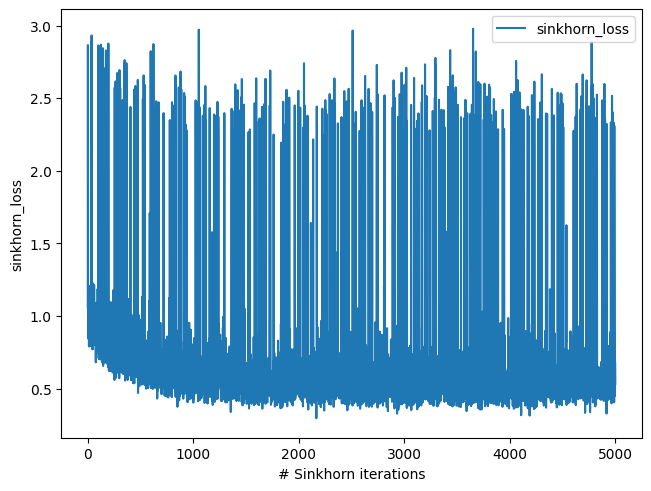

In [ ]:
sinkhorn_loss_mnar25 = torch.tensor(sinkhorn_loss_mnar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mnar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mnar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

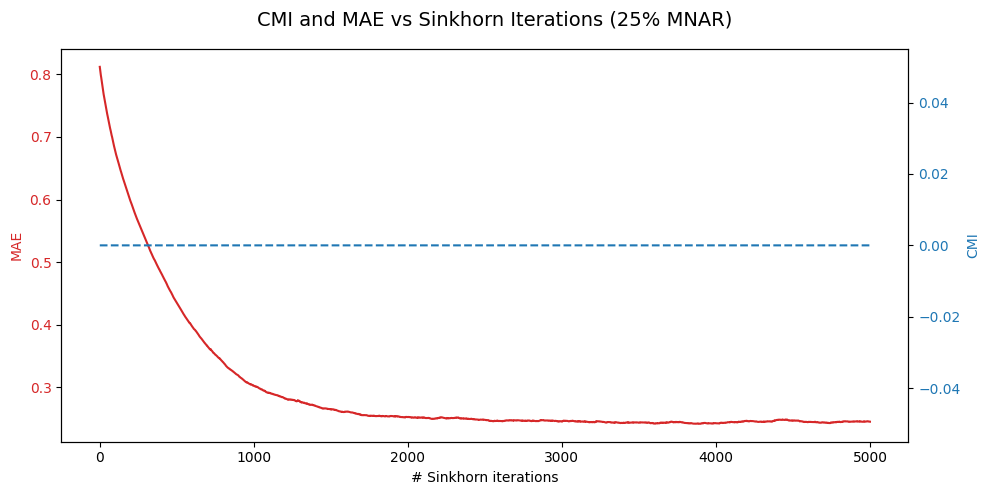

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mnar25
mae_array = sk_maes25mnar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MNAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

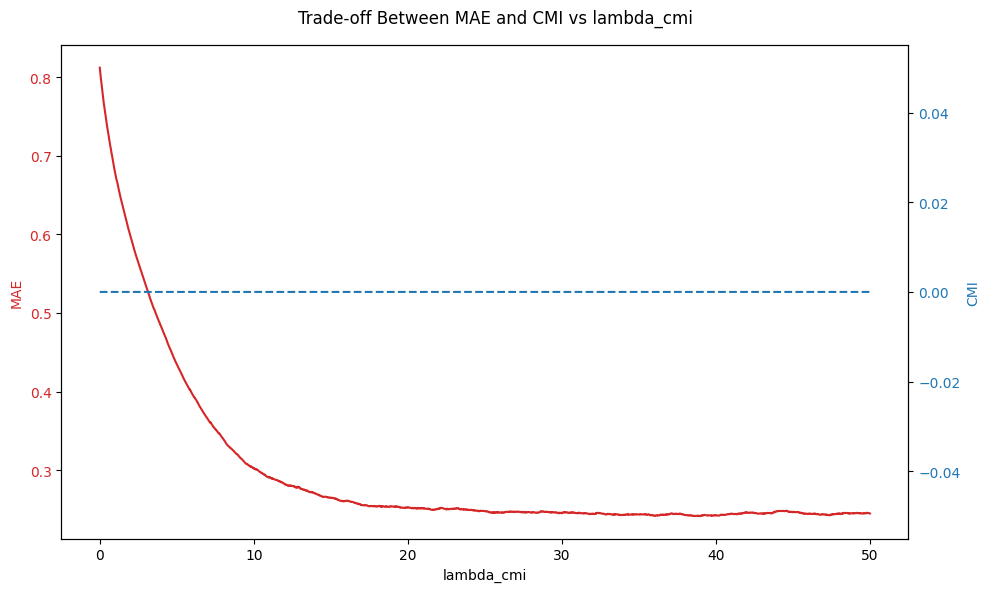

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mnar25 # list of length 2000 from your model
mae_history = sk_maes25mnar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mnar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


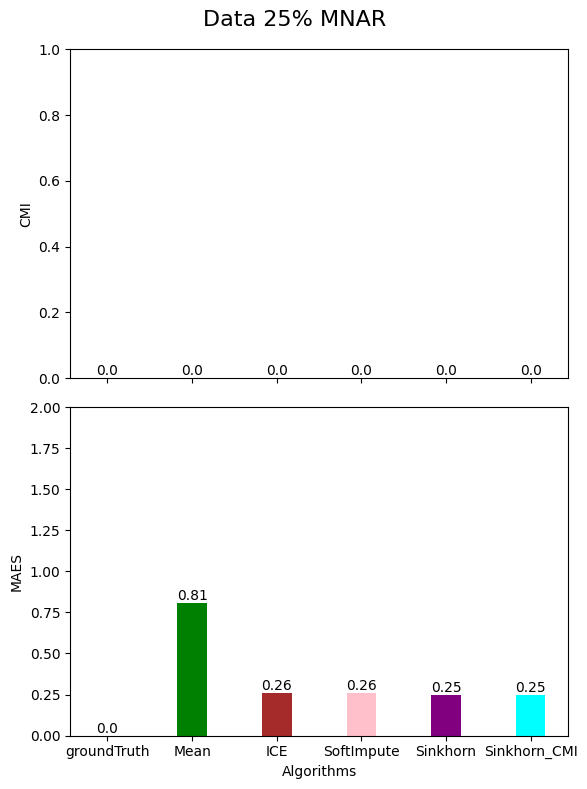

In [ ]:

# Define values and categories
values_cmi_mnar25 = [cmi_groundTruth.detach(),cmi_mean_mnar25.detach(),cmi_ice_mnar25.detach(),cmi_soft_mnar25.detach(),on_cmi_missmnar25.detach(),cmi_mnar25.detach()]
values_maes_mnar25 = [0.0,mean_mae_mnar25.detach(),ice_mae_mnar25.detach(), soft_mae_mnar25.detach(),on_sk_mae_mnar25.detach(),sk_mae_mnar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MNAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mnar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAES bars and add values on top
bars2 = ax2.bar(index, values_maes_mnar25, color=colors, width=bar_width)
ax2.set_ylabel("MAES")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show()


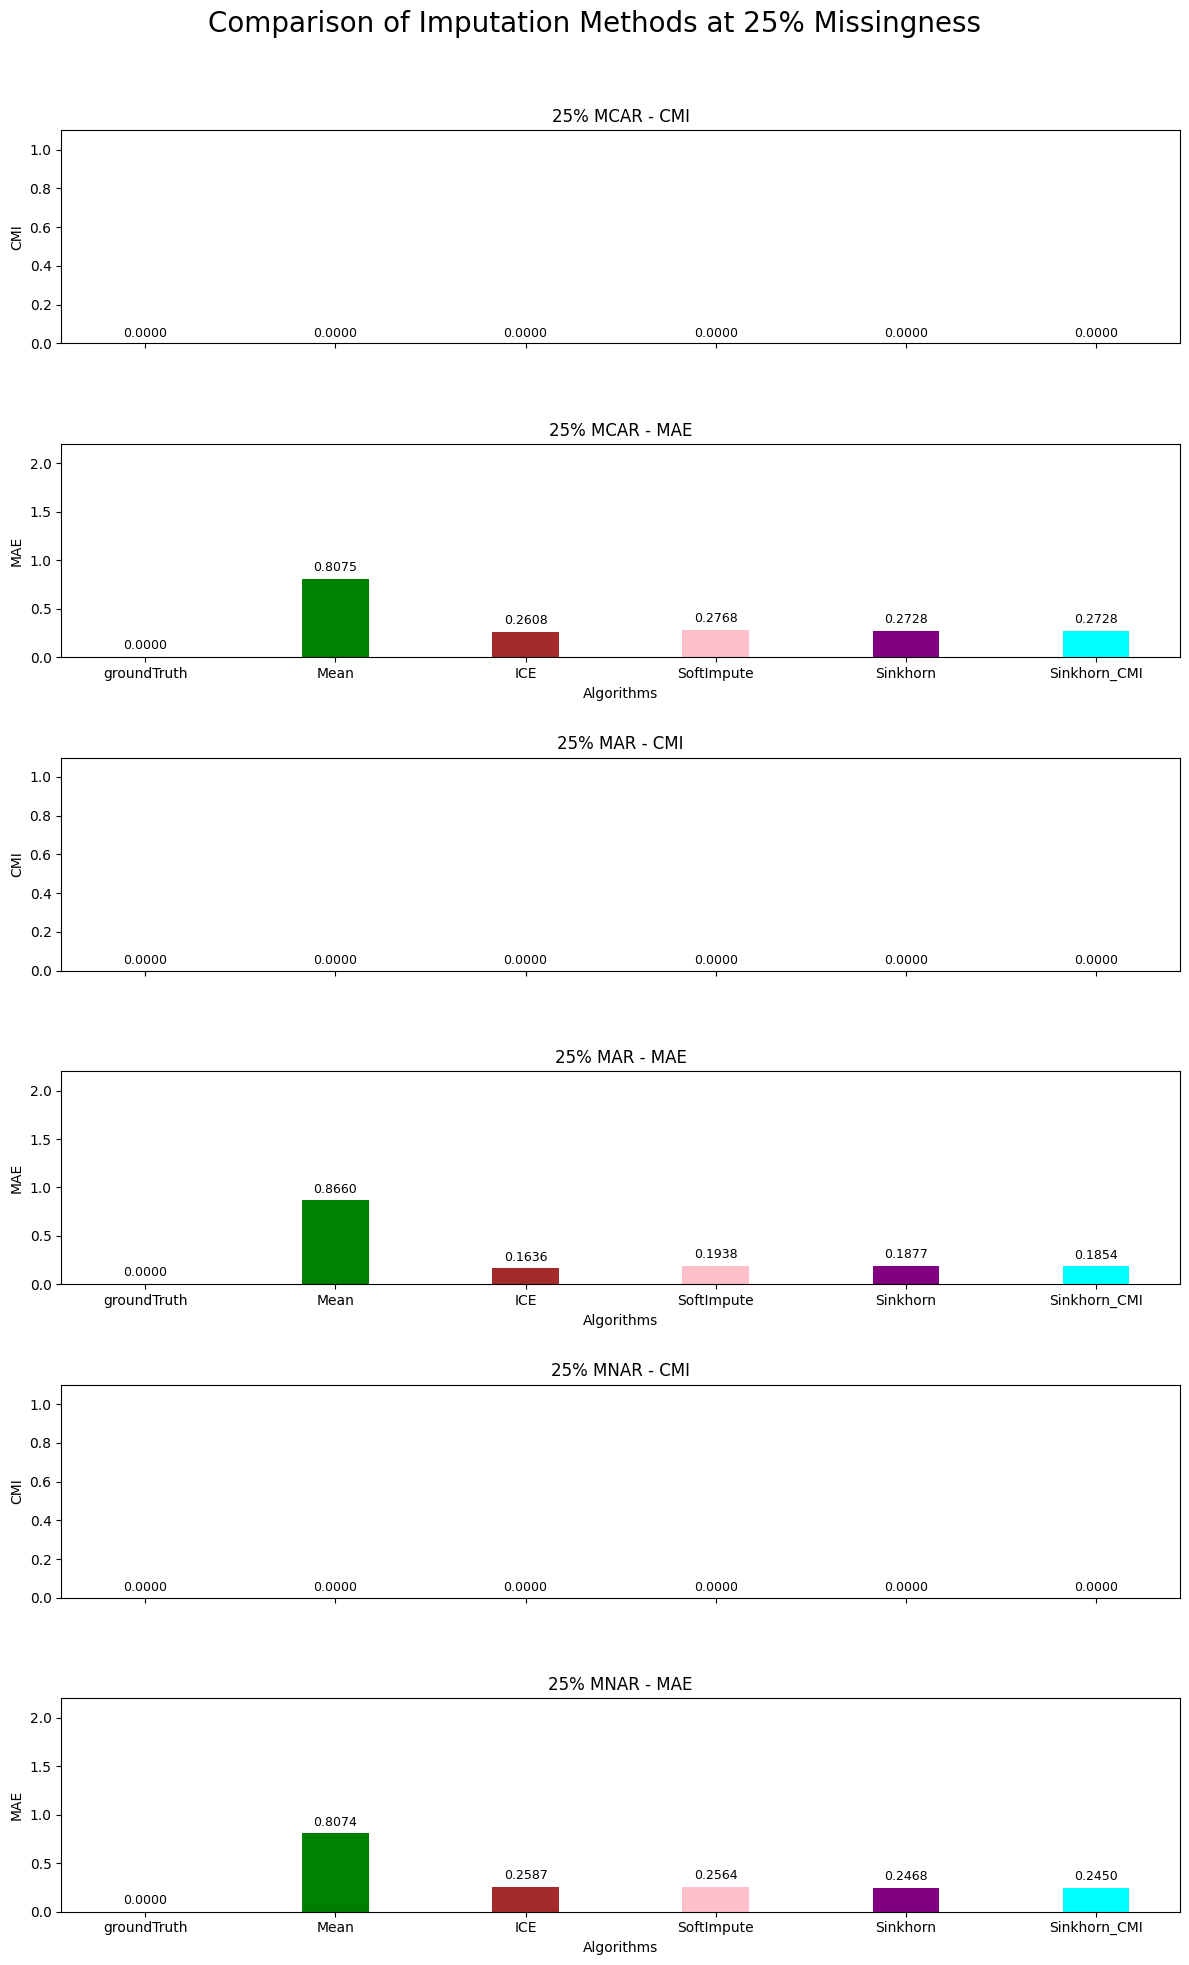

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(12, 20), sharex=False)
fig.suptitle('Comparison of Imputation Methods at 25% Missingness', fontsize=20)

# MCAR, MAR, MNAR order
plot_data = [
    ("25% MCAR", values_cmi_mcar25, values_maes_mcar25),
    ("25% MAR", values_cmi_mar25, values_maes_mar25),
    ("25% MNAR", values_cmi_mnar25, values_maes_mnar25),
]

for i, (title, cmi_vals, mae_vals) in enumerate(plot_data):
    ax_cmi = axes[i * 2]
    ax_mae = axes[i * 2 + 1]

    # ----------------- CMI Plot -----------------
    bars1 = ax_cmi.bar(index, cmi_vals, color=colors, width=bar_width)
    ax_cmi.set_ylabel("CMI")
    ax_cmi.set_ylim(0, 1.1)
    ax_cmi.set_title(f"{title} - CMI")
    for bar in bars1:
        yval = bar.get_height()
        ax_cmi.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

    # Remove x-axis labels and ticks for CMI
    ax_cmi.set_xticks(index)
    ax_cmi.set_xticklabels([])

    # ----------------- MAE Plot -----------------
    bars2 = ax_mae.bar(index, mae_vals, color=colors, width=bar_width)
    ax_mae.set_ylabel("MAE")
    ax_mae.set_ylim(0, 2.2)
    ax_mae.set_title(f"{title} - MAE")
    for bar in bars2:
        yval = bar.get_height()
        ax_mae.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

    ax_mae.set_xticks(index)
    ax_mae.set_xticklabels(categories, fontsize=10, rotation=0)
    ax_mae.set_xlabel("Algorithms")

plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.5)
plt.show()


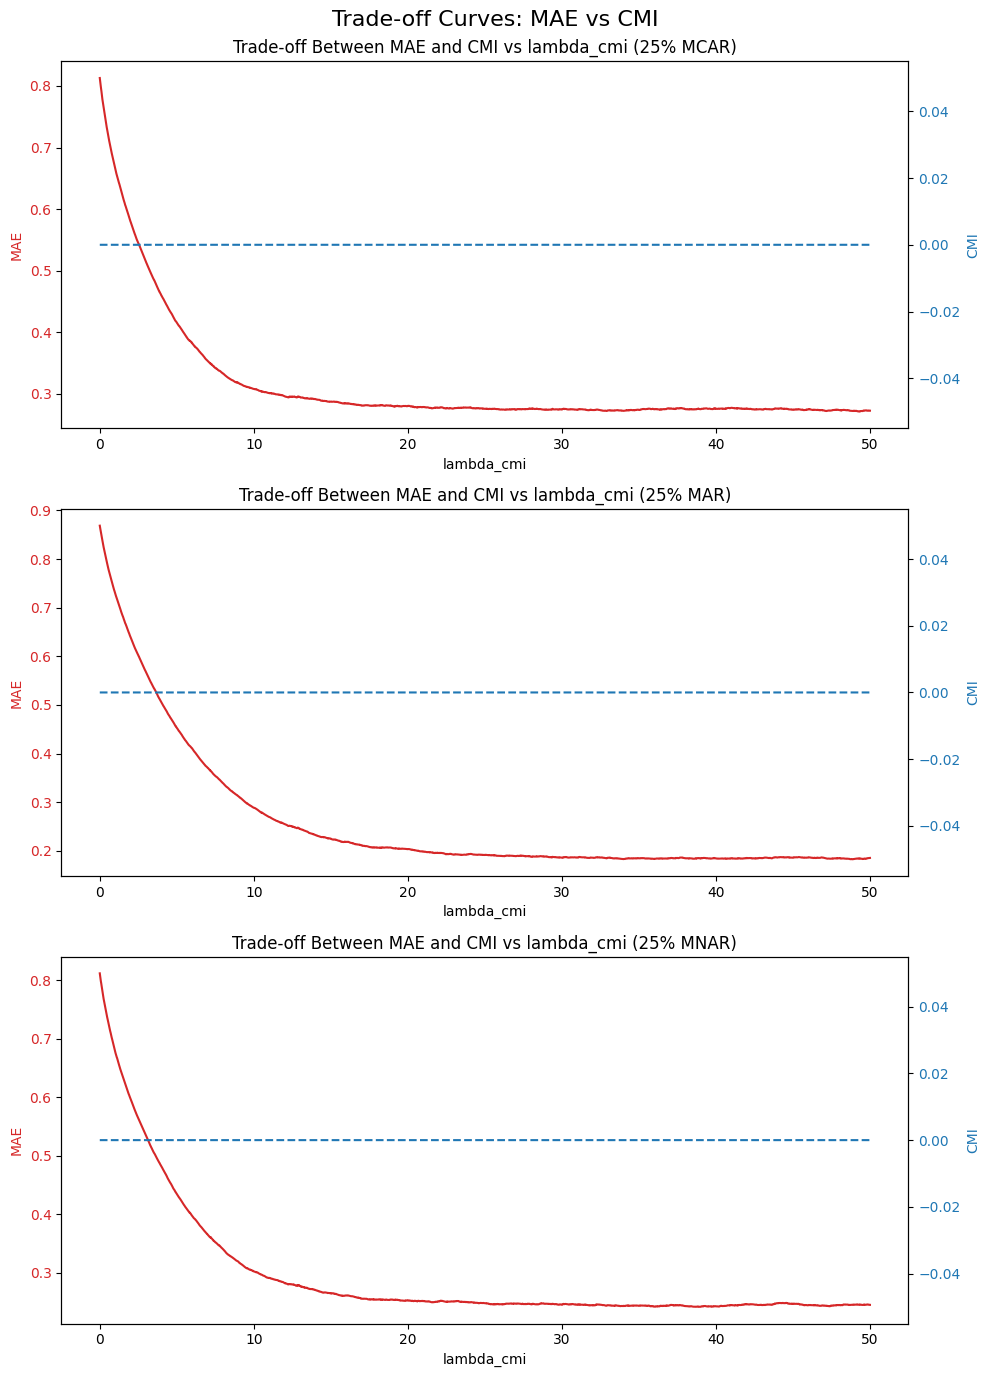

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# New order: MCAR, MAR, MNAR
datasets = [
    ("25% MCAR", lamda_cmi_mcar25, sk_maes25mcar, cmi_loss_mcar25),
    ("25% MAR", lamda_cmi_mar25, sk_maes25mar, cmi_loss_mar25),
    ("25% MNAR", lamda_cmi_mnar25, sk_maes25mnar, cmi_loss_mnar25),
]

for i, (title, lambda_vals, mae_vals, cmi_vals) in enumerate(datasets):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # MAE (left y-axis)
    ax1.set_ylabel('MAE', color='tab:red')
    ax1.plot(lambda_vals, mae_vals, color='tab:red', label='MAE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # CMI (right y-axis)
    ax2.set_ylabel('CMI', color='tab:blue')
    ax2.plot(lambda_vals, cmi_vals, color='tab:blue', linestyle='--', label='CMI')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax1.set_title(f'Trade-off Between MAE and CMI vs lambda_cmi ({title})')
    ax1.set_xlabel('lambda_cmi')

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('Trade-off Curves: MAE vs CMI', fontsize=16)
plt.show()


### Machine Learning

In [ ]:
print(torch.unique(sk_imp_mcar25[:,19]))

IndexError: index 19 is out of bounds for dimension 1 with size 9

In [ ]:
print(torch.unique(sk_imp_mnar25[:,19]))

tensor([-1.0449, -1.0188, -0.9763, -0.9693, -0.9603, -0.9588, -0.9552, -0.8844,
        -0.8642, -0.8615, -0.8417, -0.7862, -0.7830, -0.7809, -0.7321, -0.6968,
        -0.6871, -0.6835, -0.6657, -0.6587, -0.6424, -0.6146, -0.5584, -0.5458,
        -0.5439, -0.5216, -0.4593, -0.4325, -0.3721, -0.3705, -0.3296, -0.2549,
        -0.1553, -0.1222, -0.0998, -0.0942, -0.0565, -0.0365, -0.0173, -0.0105,
         0.0284,  0.0427,  0.0459,  0.0605,  0.0737,  0.0885,  0.1289,  0.1388,
         0.1733,  0.1943,  0.2042,  0.2191,  0.2218,  0.2235,  0.2279,  0.2293,
         0.2444,  0.2461,  0.2485,  0.2494,  0.2501,  0.2532,  0.2678,  0.2791,
         0.2844,  0.2906,  0.3018,  0.3051,  0.3140,  0.3182,  0.3188,  0.3196,
         0.3244,  0.3326,  0.3333,  0.3417,  0.3443,  0.3468,  0.3503,  0.3510,
         0.3511,  0.3512,  0.3598,  0.3650,  0.3700,  0.3716,  0.3751,  0.3817,
         0.3849,  0.3871,  0.3873,  0.3873,  0.3883,  0.3960,  0.4039,  0.4080,
         0.4083,  0.4084,  0.4103,  0.41

In [ ]:
#sex_col = sk_cmi_imp_mcar25[:, 19]
#sex_binary = (sex_col >= 0.5).int()  # or use 0.5 as threshold
#sk_cmi_imp_mcar25[:, 19] = sex_binary


In [ ]:
print(sk_imp_mcar25[:, 19])

tensor([ 0.6695, -1.4936,  0.6774,  0.7054,  0.4991,  0.6695,  0.6695,  0.6695,
         0.6695,  0.6592, -1.5283, -1.4936, -1.4936,  0.6695, -1.4936, -1.4936,
         0.6695,  0.3936, -1.4936,  0.6695,  1.2599,  0.6695,  0.6695,  0.6695,
         0.6634,  0.6695,  0.6695, -1.4936,  0.0641,  1.0714,  0.6695,  0.6722,
         0.6695,  0.6695, -1.4936,  0.6695,  0.6927,  0.6695,  0.6824,  0.6695,
         0.6695,  0.6750,  0.6695, -2.3363, -1.4936,  0.6846,  0.6695, -1.4936,
        -0.0724, -1.4936,  0.6695,  0.6695,  0.6695,  0.6695,  0.6695,  0.6695,
         0.6695,  0.6664, -1.4936, -0.1097,  0.7248,  0.6695,  0.1311,  0.6695,
        -1.4936,  0.7166, -1.4936,  0.6695,  0.6695, -1.4936, -1.4936, -2.1371,
         0.6695,  0.6748,  0.6810,  0.6695,  0.6695, -1.6619,  0.6695,  0.6848,
        -1.4936,  0.6695, -1.4936,  0.7021,  0.6911, -1.4936,  0.6645,  0.0112,
         0.6848,  0.6695,  0.6695,  1.2966, -1.4936,  0.6365,  0.6695,  0.6695,
        -1.4936,  0.6695,  0.7454,  0.66

In [ ]:
sk_imp_mnar25[:,19]

tensor([ 0.2461, -1.0449,  0.8979,  0.5624,  0.9570,  0.7679,  2.9780,  0.9570,
         0.8203,  0.9620,  0.8652,  0.6273,  0.3326,  0.9570,  0.5564,  0.7520,
         5.9360,  0.8456, -1.0449,  0.9570,  0.9570,  0.7110,  0.9216,  0.7908,
         0.9680,  0.6477,  0.9794, -0.0365,  0.7161,  0.5030,  1.0389,  0.4958,
         0.5296,  6.1926, -1.0449,  0.9570,  0.9570,  0.9570,  0.5608,  0.6835,
         0.9570,  0.9570,  0.6243,  0.9007, -1.0449, -1.0449,  1.0150, -0.9763,
         0.9096,  0.5336, -0.8417,  0.4251,  0.9570,  0.9570,  0.8245,  0.9570,
         0.6273, -1.0449,  0.6759, -1.0449,  1.2117,  0.5729,  0.9570,  0.2279,
        -0.5439,  0.7986, -1.0449,  0.9316,  0.7650,  0.6028,  0.5226,  0.9570,
         0.9570, -1.0449,  0.5583,  0.9570,  0.9570,  0.9570,  0.3018,  0.8065,
         0.3244,  0.9689,  0.7516, -1.0449,  0.8303, -1.0449, -1.0449,  0.9570,
         1.0303, -0.9588,  0.8296,  1.2067, -1.0449,  0.6990,  0.9570,  0.3598,
        -1.0449,  0.4507,  0.9570,  6.70